In [25]:
# ======================================================================
# CELL 1: Imports & Basic Setup
# ======================================================================

import os, re, glob, math, gc, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


✅ Imports successful!
PyTorch version: 2.8.0+cu126
CUDA available: True


In [26]:
# ======================================================================
# CELL 2: Global Configuration & Hyperparameters
# ======================================================================

# ---------------- DATASET CONFIG ----------------
BASE = r"E:\Collaboration Work\With Farooq\phm dataset\PHM Challange 2010 Milling"

TRAIN_CUTTERS = ["c1", "c4", "c6"]   # have wear labels (EOL known)
TEST_CUTTERS  = ["c2", "c3", "c5"]   # unlabeled, EOL will be inferred

# Windowing parameters for feature extraction
WIN = 4096
HOP = 2048
MAX_WINDOWS = 96
SAMPLING_RATE = 50000

# ---------------- PHYSICS (Taylor wear) ----------------
TAYLOR_PARAMS = {
    'C': 1e-8,
    'alpha': 0.13,
    'beta': 0.77,
    'gamma': 0.37,
    'delta': 0.5
}

# ---------------- MODEL ARCHITECTURE ----------------
INPUT_DIM = 126              # 18 features × 7 channels
HIDDEN_DIM = 256
STATE_DIM = 32
DROPOUT = 0.3

# Latent EOL head
EOL_HIDDEN_DIM = 64          # size of hidden layer before scalar EOL output

# ---------------- TRAINING ----------------
LR = 1e-3
EPOCHS = 200                 # we can adjust later with early stopping
BATCH_SIZE = 16
VAL_RATIO = 0.15
SEED = 42

# ---------------- LOSS WEIGHTS ----------------
LAMBDA_PHYSICS = 0.5         # physics-informed loss
LAMBDA_MONOTONIC = 0.4       # monotonicity loss
LAMBDA_UNCERTAINTY = 0.2     # NLL-based uncertainty regularization
LAMBDA_EOL = 0.1             # ⬅ NEW: EOL supervision / regularization

MTL_WEIGHTS = {              # for normalized targets
    'f1': 0.2,
    'f2': 0.2,
    'f3': 0.2,
    'wear': 1.0,
    'rul': 1.2
}

# ---------------- REPRODUCIBILITY ----------------
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.set_default_dtype(torch.float32)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\n" + "="*60)
print(f"🖥️  Device: {device}")
print(f"📊 Dataset: PHM Challenge 2010 Milling")
print(f"🔬 Model: Hierarchical Physics-Informed Latent-EOL State-Space RUL")
print("="*60 + "\n")



🖥️  Device: cuda
📊 Dataset: PHM Challenge 2010 Milling
🔬 Model: Hierarchical Physics-Informed Latent-EOL State-Space RUL



In [27]:
# ======================================================================
# CELL 3: Data Loading Utilities (Wear Tables + Cut Files)
# ======================================================================

def read_wear_table(cutter_dir):
    """
    Read the wear CSV for a given cutter directory.
    Returns:
      wear_df:  DataFrame with columns:
                ['Cut_Number', 'flute_1','flute_2','flute_3',
                 'wear_max','f1_norm','f2_norm','f3_norm',
                 'wear_norm','RUL','rul_norm']
      EOL:      float, maximum wear (end-of-life) for this cutter
    """
    # Find wear file
    candidates = [
        p for p in glob.glob(os.path.join(cutter_dir, "*.csv"))
        if "wear" in os.path.basename(p).lower()
    ]
    if not candidates:
        raise FileNotFoundError(f"No wear CSV found in {cutter_dir}")
    wear_file = candidates[0]

    # Try to infer header presence
    raw0 = pd.read_csv(wear_file, sep=None, engine="python", nrows=5)
    try:
        v = pd.to_numeric(raw0.iloc[0, 0], errors="coerce")
        use_header = bool(pd.isna(v))
    except Exception:
        use_header = True

    # Load full file
    if use_header:
        raw = pd.read_csv(wear_file, sep=None, engine="python")
    else:
        raw = pd.read_csv(wear_file, sep=None, engine="python", header=None)

    raw.columns = [str(c).strip().lower() for c in raw.columns]

    def first_present(names):
        for n in names:
            if n in raw.columns:
                return n
        return None

    cut_col = first_present(["cut", "cut_number", "cut no", "cut_no", "c", "index", "id", "0"])
    f1_col  = first_present(["flute_1", "flute1", "f1", "flute 1", "1"])
    f2_col  = first_present(["flute_2", "flute2", "f2", "flute 2", "2"])
    f3_col  = first_present(["flute_3", "flute3", "f3", "flute 3", "3"])

    # Fallback: just assume first 4 non-empty columns
    if cut_col is None or f1_col is None or f2_col is None or f3_col is None:
        tmp = raw.copy().dropna(axis=1, how="all")
        assert tmp.shape[1] >= 4, "Wear file must have ≥4 usable columns"
        tmp.columns = [f"col_{i}" for i in range(tmp.shape[1])]
        cut_col, f1_col, f2_col, f3_col = "col_0", "col_1", "col_2", "col_3"
        raw = tmp

    # Clean up cut numbers
    cut_series = raw[cut_col].astype(str).str.extract(r"(\d+)", expand=False)
    cut_series = pd.to_numeric(cut_series, errors="coerce")

    f1 = pd.to_numeric(raw[f1_col], errors="coerce")
    f2 = pd.to_numeric(raw[f2_col], errors="coerce")
    f3 = pd.to_numeric(raw[f3_col], errors="coerce")

    df = pd.DataFrame({
        "Cut_Number": cut_series,
        "flute_1": f1,
        "flute_2": f2,
        "flute_3": f3
    }).dropna()

    df["Cut_Number"] = df["Cut_Number"].round().astype(int)

    # Max wear per cut and cutter-level EOL
    df["wear_max"] = df[["flute_1", "flute_2", "flute_3"]].max(axis=1)
    EOL = float(df["wear_max"].max())

    eps = 1e-9
    df["f1_norm"] = df["flute_1"] / (EOL + eps)
    df["f2_norm"] = df["flute_2"] / (EOL + eps)
    df["f3_norm"] = df["flute_3"] / (EOL + eps)
    df["wear_norm"] = df["wear_max"] / (EOL + eps)

    # RUL in raw and normalized units
    df["RUL"] = EOL - df["wear_max"]
    df["rul_norm"] = df["RUL"] / (EOL + eps)

    df = df.sort_values("Cut_Number").reset_index(drop=True)
    return df, EOL


def discover_cut_files(cutter_dir, cutter_id):
    """
    Find all non-wear CSVs corresponding to individual cuts for this cutter.
    Returns a dict: {cut_number: path_to_csv}
    """
    all_csvs = glob.glob(os.path.join(cutter_dir, "**", "*.csv"), recursive=True)
    all_csvs = [p for p in all_csvs if "wear" not in os.path.basename(p).lower()]

    cuts = {}
    for p in all_csvs:
        name = os.path.basename(p).lower()
        # Common patterns: c1_123.csv, c1-123.csv, 123.csv, etc.
        m = (re.search(rf"c[_-]?{cutter_id}[_-]?(\d+)\.csv$", name)
             or re.search(r"(\d+)\.csv$", name))
        if m:
            cutn = int(m.group(1))
            cuts[cutn] = p

    return dict(sorted(cuts.items()))


def extract_cutting_parameters(cut_number, cutter_name):
    """
    Simple deterministic cutting parameters for each cut.
    You can later extend this if you want to include more process info.
    """
    spindle_speed = 10400             # rpm
    feed_rate = 1555                  # mm/min
    tool_diameter = 12.0              # mm
    cutting_speed = (math.pi * tool_diameter * spindle_speed) / 1000.0  # m/min
    depth_of_cut = 0.5                # mm
    cumulative_time = float(cut_number)   # proxy for time / number of cuts

    return {
        "V": cutting_speed,
        "f": feed_rate / 1000.0,      # m/min-ish scale
        "d": depth_of_cut,
        "t": cumulative_time,
        "N": spindle_speed,
        "cutter": cutter_name
    }

print("✅ Data loading utilities defined!")


✅ Data loading utilities defined!


In [28]:
# ======================================================================
# CELL 4: Advanced Feature Extraction (Time + Frequency)
# ======================================================================

def extract_time_domain_features(x: np.ndarray) -> np.ndarray:
    """
    Compute basic time-domain features for a 1D signal x.
    Returns a 10-dimensional feature vector.
    """
    if x.size == 0:
        return np.zeros(10, dtype=np.float32)

    mean = float(np.mean(x))
    std = float(np.std(x))
    rms = float(np.sqrt(np.mean(x ** 2)))
    peak = float(np.max(np.abs(x)))

    if std > 1e-9:
        z = (x - mean) / (std + 1e-9)
        skewness = float(np.mean(z ** 3))
        kurtosis = float(np.mean(z ** 4))
    else:
        skewness = 0.0
        kurtosis = 0.0

    crest_factor = peak / (rms + 1e-9)
    impulse_factor = peak / (np.mean(np.abs(x)) + 1e-9)
    peak_to_peak = float(np.ptp(x))
    energy = float(np.sum(x ** 2))

    return np.array(
        [mean, std, rms, peak,
         crest_factor, skewness, kurtosis,
         impulse_factor, peak_to_peak, energy],
        dtype=np.float32
    )


def extract_frequency_domain_features(x: np.ndarray, fs: int = SAMPLING_RATE) -> np.ndarray:
    """
    Compute simple spectral features from the power spectrum of x.
    Returns an 8-dimensional feature vector.
    """
    if x.size == 0:
        return np.zeros(8, dtype=np.float32)

    # Real FFT and power spectrum
    X = np.fft.rfft(x, n=len(x))
    P = np.abs(X) ** 2
    freqs = np.fft.rfftfreq(len(x), d=1.0 / fs)

    total_power = float(P.sum())
    if total_power < 1e-12:
        return np.zeros(8, dtype=np.float32)

    centroid = float((freqs * P).sum() / total_power)
    spread = float(np.sqrt(((freqs - centroid) ** 2 * P).sum() / total_power))

    if spread > 1e-9:
        spec_skew = float((((freqs - centroid) ** 3 * P).sum() / total_power) /
                          (spread ** 3 + 1e-9))
        spec_kurt = float((((freqs - centroid) ** 4 * P).sum() / total_power) /
                          (spread ** 4 + 1e-9))
    else:
        spec_skew = 0.0
        spec_kurt = 0.0

    # Simple band powers (example bands: [0,5k), [5k,15k), [15k,25k))
    low_band = P[(freqs >= 0) & (freqs < 5000)].sum()
    mid_band = P[(freqs >= 5000) & (freqs < 15000)].sum()
    high_band = P[(freqs >= 15000) & (freqs < 25000)].sum()

    low_ratio = float(low_band / (total_power + 1e-9))
    mid_ratio = float(mid_band / (total_power + 1e-9))
    high_ratio = float(high_band / (total_power + 1e-9))

    return np.array(
        [total_power, centroid, spread, spec_skew, spec_kurt,
         low_ratio, mid_ratio, high_ratio],
        dtype=np.float32
    )


def extract_window_features(x: np.ndarray, fs: int = SAMPLING_RATE) -> np.ndarray:
    """
    Compute concatenated time + frequency features for a 1D window x.
    10 (time) + 8 (freq) = 18 features.
    """
    time_feats = extract_time_domain_features(x)
    freq_feats = extract_frequency_domain_features(x, fs)
    return np.concatenate([time_feats, freq_feats], axis=0)


def extract_cut_windows(path: str,
                        win: int = WIN,
                        hop: int = HOP,
                        max_windows: int = MAX_WINDOWS):
    """
    Read a raw cut CSV file and convert it into a fixed-length [T, F] feature tensor:
      - T = max_windows
      - F = 18 features × 7 channels = 126

    Returns:
      F:  np.ndarray of shape [max_windows, 126] (float32)
      T:  int, number of *valid* windows before padding/truncation
    """
    try:
        df = pd.read_csv(path, header=None, engine="c", low_memory=False)
    except Exception:
        df = pd.read_csv(path, header=None, engine="python", low_memory=False)

    # Drop empty columns and keep first 7 as channels
    df = df.dropna(axis=1, how="all")
    if df.shape[1] < 7:
        # Not enough channels -> signal missing
        return None

    arr = df.iloc[:, :7].to_numpy(dtype=np.float32, copy=False)  # [N, 7]
    N = arr.shape[0]
    feats = []

    if N >= win:
        # Sliding windows
        for start in range(0, N - win + 1, hop):
            seg = arr[start:start + win, :]  # [win, 7]
            window_feat = []
            for ch in range(7):
                ch_feat = extract_window_features(seg[:, ch])
                window_feat.append(ch_feat)
            feats.append(np.concatenate(window_feat, axis=0))  # [126]

            if len(feats) >= max_windows:
                break
    else:
        # Single short window
        seg = arr
        window_feat = []
        for ch in range(7):
            ch_feat = extract_window_features(seg[:, ch])
            window_feat.append(ch_feat)
        feats.append(np.concatenate(window_feat, axis=0))

    F = np.stack(feats, axis=0)        # [T, 126]
    T = F.shape[0]

    # Pad or truncate to max_windows
    if T < max_windows:
        pad = np.zeros((max_windows - T, F.shape[1]), dtype=np.float32)
        F = np.concatenate([F, pad], axis=0)
    else:
        F = F[:max_windows]
        T = max_windows

    return F, T


print("✅ Advanced feature extraction defined!")
print(f"   - Per channel: 18 features × 7 channels = {18 * 7} features/window")


✅ Advanced feature extraction defined!
   - Per channel: 18 features × 7 channels = 126 features/window


In [29]:
# ======================================================================
# CELL 5: Build Dataset Index (Train/Test) + EOL Map
# ======================================================================

def build_index_for_cutters(cutters, labeled=True):
    """
    Build a list of sample dictionaries for each cutter.
    
    Each entry in 'index' has:
      - 'cutter': cutter name (e.g., 'c1')
      - 'cut_number': integer cut index
      - 'path': path to signal CSV
      - 'prev_path': path to previous cut's CSV (or None)
      - 'y_norm': np.array(5,) normalized [f1,f2,f3,wear,rul] (if labeled)
      - 'y_raw':  np.array(5,) raw [f1,f2,f3,wear,RUL] (if labeled)
      - 'eol':    float EOL for this cutter (if labeled, same for all its cuts)
      - 'cutting_params': dict of process parameters
    """
    index = []
    eol_map = {}
    cutting_params_list = []

    for cname in cutters:
        cutter_dir = os.path.join(BASE, cname)
        cutter_id = int(re.findall(r"\d+", cname)[0])

        # Discover signal files for this cutter
        cut_files = discover_cut_files(cutter_dir, cutter_id)

        if labeled:
            # Read wear table and EOL
            wear_df, EOL = read_wear_table(cutter_dir)
            eol_map[cname] = EOL

            # Cuts present in both wear table and signal files
            present_cuts = sorted(
                set(wear_df["Cut_Number"].astype(int)).intersection(cut_files.keys())
            )

            for cutn in present_cuts:
                row = wear_df.loc[wear_df["Cut_Number"] == cutn].iloc[0]

                # Normalized targets (all in [0,1])
                y_norm = np.array(
                    [row["f1_norm"],
                     row["f2_norm"],
                     row["f3_norm"],
                     row["wear_norm"],
                     row["rul_norm"]],
                    dtype=np.float32
                )

                # Raw targets (μm or wear units)
                y_raw = np.array(
                    [row["flute_1"],
                     row["flute_2"],
                     row["flute_3"],
                     row["wear_max"],
                     row["RUL"]],
                    dtype=np.float32
                )

                cut_params = extract_cutting_parameters(cutn, cname)

                prev_cut = cutn - 1 if (cutn - 1) in present_cuts else None

                index.append({
                    "cutter": cname,
                    "cut_number": int(cutn),
                    "path": cut_files[int(cutn)],
                    "prev_path": cut_files[prev_cut] if prev_cut is not None else None,
                    "y_norm": y_norm,
                    "y_raw": y_raw,
                    "eol": float(EOL),
                    "cutting_params": cut_params,
                })
                cutting_params_list.append(cut_params)

        else:
            # Unlabeled cutters: we still list all cuts, but y_* and eol remain None
            present_cuts = sorted(cut_files.keys())
            for cutn in present_cuts:
                cut_params = extract_cutting_parameters(cutn, cname)
                prev_cut = cutn - 1 if (cutn - 1) in present_cuts else None

                index.append({
                    "cutter": cname,
                    "cut_number": int(cutn),
                    "path": cut_files[int(cutn)],
                    "prev_path": cut_files[prev_cut] if prev_cut is not None else None,
                    "y_norm": None,
                    "y_raw": None,
                    "eol": None,
                    "cutting_params": cut_params,
                })
                cutting_params_list.append(cut_params)

    return index, eol_map, cutting_params_list


# Build indices for train and test cutters
train_index, train_eols, train_params = build_index_for_cutters(TRAIN_CUTTERS, labeled=True)
test_index,  test_eols_dummy, test_params  = build_index_for_cutters(TEST_CUTTERS,  labeled=False)

# Reference EOL: median over training cutters (used as prior)
EOL_REF = float(np.median(list(train_eols.values())))

print(f"\n📊 Dataset Summary:")
print("=" * 60)
print(f"Train samples: {len(train_index)}")
print(f"Test samples:  {len(test_index)}")
print("\n🔧 Train EOLs:")
for k, v in train_eols.items():
    print(f"   {k}: {v:.2f}")
print(f"\n📐 EOL Reference (median): {EOL_REF:.2f}")
print("=" * 60 + "\n")



📊 Dataset Summary:
Train samples: 945
Test samples:  945

🔧 Train EOLs:
   c1: 172.69
   c4: 210.92
   c6: 234.72

📐 EOL Reference (median): 210.92



In [30]:
# ======================================================================
# CELL 6: Physics-Informed Wear Model & Losses
# ======================================================================

class TaylorWearModel:
    """
    Simple parametric wear model (Taylor-type) used as a physics prior:
        wear_raw = C * V^alpha * f^beta * d^gamma * t^delta
    where:
      V: cutting speed
      f: feed per minute (approx)
      d: depth of cut
      t: cumulative cutting time / number of cuts
    """
    def __init__(self, params=TAYLOR_PARAMS):
        self.C = params["C"]
        self.alpha = params["alpha"]
        self.beta = params["beta"]
        self.gamma = params["gamma"]
        self.delta = params["delta"]

    def predict_wear(self, V, f, d, t):
        wear = (self.C
                * (V ** self.alpha)
                * (f ** self.beta)
                * (d ** self.gamma)
                * (t ** self.delta))
        return wear


def physics_informed_loss(
    wear_pred_norm: torch.Tensor,
    cutting_params: torch.Tensor,
    eol_used: torch.Tensor,
    taylor_model: TaylorWearModel,
):
    """
    Physics-informed loss on *normalized* wear.

    Args:
      wear_pred_norm: [B] predicted normalized wear in [0,1] from the network.
      cutting_params: [B, 4] tensor with columns [V, f, d, t].
      eol_used:       [B] tensor with EOL values (can be true or predicted).
      taylor_model:   instance of TaylorWearModel.

    Returns:
      scalar tensor loss.
    """
    # Unpack cutting parameters
    V = cutting_params[:, 0]
    f = cutting_params[:, 1]
    d = cutting_params[:, 2]
    t = cutting_params[:, 3]

    # Compute raw wear from physics
    wear_physics_raw = taylor_model.predict_wear(V, f, d, t)  # numpy-like ops
    # Convert to torch on same device/dtype as wear_pred_norm
    wear_physics_raw = torch.as_tensor(
        wear_physics_raw,
        dtype=wear_pred_norm.dtype,
        device=wear_pred_norm.device,
    )

    # Normalize by EOL (true or predicted)
    eps = 1e-9
    eol_clamped = torch.clamp(eol_used, min=eps)  # avoid division by zero
    wear_physics_norm = wear_physics_raw / eol_clamped
    wear_physics_norm = torch.clamp(wear_physics_norm, 0.0, 1.0)

    # Only use samples where EOL is finite and positive
    mask = torch.isfinite(eol_used) & (eol_used > 0)
    if mask.sum() == 0:
        # No valid physics signal in this batch
        return torch.tensor(0.0, device=wear_pred_norm.device)

    loss = F.mse_loss(wear_pred_norm[mask], wear_physics_norm[mask])
    return loss


def monotonicity_loss(
    wear_curr: torch.Tensor,
    wear_prev: torch.Tensor,
    mask_prev: torch.Tensor,
):
    """
    Penalize non-monotonic wear: enforce wear_curr >= wear_prev.

    Args:
      wear_curr: [B] current normalized wear predictions.
      wear_prev: [B] previous normalized wear predictions (aligned).
      mask_prev: [B] 1.0 where previous cut exists, 0.0 otherwise.

    Returns:
      scalar tensor loss.
    """
    if mask_prev.sum() == 0:
        return torch.tensor(0.0, device=wear_curr.device)

    # Violation where wear_prev > wear_curr
    violation = F.relu(wear_prev - wear_curr)
    loss = (violation * mask_prev).sum() / (mask_prev.sum() + 1e-9)
    return loss


# Instantiate a global physics model
taylor_model = TaylorWearModel(TAYLOR_PARAMS)

print("✅ Physics-informed model & losses defined!")


✅ Physics-informed model & losses defined!


In [31]:
# ======================================================================
# CELL 7: Dataset Class for Physics-Informed Latent-EOL Model
# ======================================================================

class PHMPhysicsLatentEOLDataset(Dataset):
    """
    Dataset for the physics-informed, latent-EOL RUL model.

    For each sample (cut), returns:
      - X:         [T, F] current cut feature sequence (padded to MAX_WINDOWS)
      - L:         scalar length T (number of valid windows)
      - Xp, Lp:    previous cut features/length (or zeros if none)
      - params:    [4] cutting parameters [V, f, d, t]
      - y_norm:    [5] normalized targets [f1,f2,f3,wear,rul] (NaNs if unlabeled)
      - y_raw:     [5] raw targets [f1,f2,f3,wear,RUL] (NaNs if unlabeled)
      - eol_true:  scalar true EOL for this cutter (NaN if unlabeled/test)
      - cut_number: int
      - cutter:     string (cutter name, e.g. 'c1')
    """

    def __init__(self, index, scaler=None, fit_scaler=False):
        """
        Args:
          index:       list of sample dicts from build_index_for_cutters(...)
          scaler:      StandardScaler or None
          fit_scaler:  if True, fit scaler on all windows from this index
        """
        self.index = index
        self.scaler = scaler

        if fit_scaler:
            stacks = []
            for it in tqdm(self.index, desc="Fitting scaler"):
                out = extract_cut_windows(it["path"])
                if out is None:
                    continue
                X, L = out
                # Only valid windows (we can use L windows)
                stacks.append(X[:int(L)])

            if len(stacks) == 0:
                raise RuntimeError("No valid signals found to fit scaler.")

            S = np.concatenate(stacks, axis=0)  # [N_total_windows, F]
            self.scaler = StandardScaler().fit(S)
            print(f"✅ Scaler fitted on {S.shape[0]} windows")

    def __len__(self):
        return len(self.index)

    def __getitem__(self, i):
        it = self.index[i]

        # -------- Current cut features --------
        out = extract_cut_windows(it["path"])
        if out is None:
            X = np.zeros((MAX_WINDOWS, INPUT_DIM), dtype=np.float32)
            L = 1
        else:
            X, L = out
            L = max(int(L), 1)

        if self.scaler is not None:
            X = self.scaler.transform(X).astype(np.float32)

        # -------- Previous cut features (for monotonic loss) --------
        if it["prev_path"] is not None:
            outp = extract_cut_windows(it["prev_path"])
            if outp is None:
                Xp = np.zeros((MAX_WINDOWS, INPUT_DIM), dtype=np.float32)
                Lp = 1
            else:
                Xp, Lp = outp
                Lp = max(int(Lp), 1)

            if self.scaler is not None:
                Xp = self.scaler.transform(Xp).astype(np.float32)
        else:
            Xp = np.zeros((MAX_WINDOWS, INPUT_DIM), dtype=np.float32)
            Lp = 0  # indicates no previous cut

        # -------- Cutting parameters --------
        cut_params = it["cutting_params"]
        params_array = np.array(
            [cut_params["V"],
             cut_params["f"],
             cut_params["d"],
             cut_params["t"]],
            dtype=np.float32
        )

        # -------- Targets & EOL --------
        if it["y_norm"] is not None:
            y_norm = it["y_norm"].astype(np.float32)
            y_raw = it["y_raw"].astype(np.float32)
            eol_true = np.float32(it["eol"])
        else:
            # Unlabeled sample (test cutters)
            y_norm = np.full((5,), np.nan, dtype=np.float32)
            y_raw = np.full((5,), np.nan, dtype=np.float32)
            eol_true = np.float32(np.nan)

        return (
            torch.from_numpy(X),                  # [T, F]
            torch.tensor(L, dtype=torch.long),    # scalar
            torch.from_numpy(Xp),                 # [T, F]
            torch.tensor(Lp, dtype=torch.long),   # scalar
            torch.from_numpy(params_array),       # [4]
            torch.from_numpy(y_norm),             # [5]
            torch.from_numpy(y_raw),              # [5]
            torch.tensor(eol_true),               # scalar
            it["cut_number"],                     # int
            it["cutter"],                         # str
        )


def collate_phm_latent_eol(batch):
    """
    Custom collate function to batch variable-length sequences.
    """
    X, L, Xp, Lp, params, yn, yr, eol_true, cutn, cutter = zip(*batch)

    X = torch.stack(X, dim=0)          # [B, T, F]
    L = torch.stack(L, dim=0)          # [B]
    Xp = torch.stack(Xp, dim=0)        # [B, T, F]
    Lp = torch.stack(Lp, dim=0)        # [B]
    params = torch.stack(params, dim=0)  # [B, 4]
    yn = torch.stack(yn, dim=0)        # [B, 5]
    yr = torch.stack(yr, dim=0)        # [B, 5]
    eol_true = torch.stack(eol_true, dim=0)  # [B]

    cutn = np.array(cutn, dtype=int)
    cutter = np.array(cutter)

    return X, L, Xp, Lp, params, yn, yr, eol_true, cutn, cutter


print("✅ Dataset class & collate function defined!")


✅ Dataset class & collate function defined!


In [32]:
# ======================================================================
# CELL 8: Build Datasets & DataLoaders
# ======================================================================

print("\n" + "=" * 70)
print("📦 Building Datasets and DataLoaders (Latent-EOL Version)")
print("=" * 70 + "\n")

# Full training dataset (used to fit scaler)
full_train_ds = PHMPhysicsLatentEOLDataset(
    train_index,
    scaler=None,
    fit_scaler=True
)

# Reuse the fitted scaler
scaler = full_train_ds.scaler

# Train/validation split
val_n = int(len(full_train_ds) * VAL_RATIO)
train_n = len(full_train_ds) - val_n

train_ds, val_ds = torch.utils.data.random_split(
    full_train_ds,
    [train_n, val_n],
    generator=torch.Generator().manual_seed(SEED)
)

# Test dataset (unlabeled cutters, same scaler)
test_ds = PHMPhysicsLatentEOLDataset(
    test_index,
    scaler=scaler,
    fit_scaler=False
)

# DataLoaders
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_phm_latent_eol,
    pin_memory=True if torch.cuda.is_available() else False,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_phm_latent_eol,
    pin_memory=True if torch.cuda.is_available() else False,
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_phm_latent_eol,
    pin_memory=True if torch.cuda.is_available() else False,
)

print(f"✅ Datasets created:")
print(f"   - Training:   {len(train_ds):4d} samples ({len(train_loader):3d} batches)")
print(f"   - Validation: {len(val_ds):4d} samples ({len(val_loader):3d} batches)")
print(f"   - Test:       {len(test_ds):4d} samples ({len(test_loader):3d} batches)\n")



📦 Building Datasets and DataLoaders (Latent-EOL Version)



Fitting scaler: 100%|██████████| 945/945 [08:41<00:00,  1.81it/s]

✅ Scaler fitted on 90647 windows
✅ Datasets created:
   - Training:    804 samples ( 51 batches)
   - Validation:  141 samples (  9 batches)
   - Test:        945 samples ( 60 batches)



In [33]:
# ======================================================================
# CELL 9: Latent-EOL Physics-Informed State-Space RUL Model
# ======================================================================

class LatentEOLPhysicsRUL(nn.Module):
    """
    Hierarchical physics-informed state-space RUL model with latent EOL.

    - LSTM encoder over window features -> latent degradation state.
    - Combines latent state with cutting parameters [V, f, d, t].
    - Predicts normalized flute wears, total wear, and RUL in [0,1].
    - Predicts log-variances for wear & RUL (aleatoric uncertainty).
    - Predicts cutter-level EOL (latent), in raw wear units.

    This EOL prediction can be:
      - supervised (train cutters have true EOL),
      - used inside physics-informed loss instead of fixed EOL.
    """

    def __init__(
        self,
        input_dim: int = INPUT_DIM,
        hidden_dim: int = HIDDEN_DIM,
        state_dim: int = STATE_DIM,
        dropout: float = DROPOUT,
        eol_hidden_dim: int = EOL_HIDDEN_DIM,
        eol_ref: float = EOL_REF,
    ):
        super().__init__()

        # ---------------- Sequence encoder ----------------
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout,
        )

        # ---------------- Latent state projection ----------------
        self.state_proj = nn.Sequential(
            nn.Linear(hidden_dim * 2, state_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(state_dim * 2, state_dim),
            nn.ReLU(),
        )

        # Combined latent + cutting parameters
        combined_dim = state_dim + 4  # 4 = [V, f, d, t]

        # ---------------- Shared representation ----------------
        self.shared = nn.Sequential(
            nn.Linear(combined_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        shared_out_dim = hidden_dim // 2

        # ---------------- Task heads (normalized outputs) ----------------
        self.head_f1 = nn.Linear(shared_out_dim, 1)
        self.head_f2 = nn.Linear(shared_out_dim, 1)
        self.head_f3 = nn.Linear(shared_out_dim, 1)
        self.head_wear = nn.Linear(shared_out_dim, 1)
        self.head_rul = nn.Linear(shared_out_dim, 1)

        # Uncertainty (log-variance) heads for normalized outputs
        self.head_wear_logvar = nn.Linear(shared_out_dim, 1)
        self.head_rul_logvar = nn.Linear(shared_out_dim, 1)

        # ---------------- Latent EOL head (raw units) ----------------
        # A small MLP -> scalar; we enforce positivity and scale by EOL_REF.
        self.head_eol = nn.Sequential(
            nn.Linear(shared_out_dim, eol_hidden_dim),
            nn.ReLU(),
            nn.Linear(eol_hidden_dim, 1),
        )

        # Reference EOL as a buffer (for scaling)
        self.register_buffer("eol_ref", torch.tensor(float(eol_ref), dtype=torch.float32))

        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths, cutting_params):
        """
        Args:
          x:              [B, T, F] feature sequences (padded).
          lengths:        [B] valid lengths (number of windows per cut).
          cutting_params: [B, 4] [V, f, d, t].

        Returns:
          predictions: dict with keys
            - 'f1','f2','f3','wear','rul' : [B] normalized outputs
            - 'eol': [B] predicted EOL (raw units)
          uncertainties: dict with keys
            - 'wear_logvar','rul_logvar' : [B]
        """
        B, T, F = x.shape

        # Clamp lengths to at least 1
        lengths_clamped = torch.clamp(lengths, min=1)

        # Pack sequences for efficient LSTM processing
        packed = nn.utils.rnn.pack_padded_sequence(
            x, lengths_clamped.cpu(), batch_first=True, enforce_sorted=False
        )

        # Encode with LSTM
        _, (h_n, _) = self.lstm(packed)  # h_n: [num_layers*2, B, hidden_dim]

        # Split last layer's forward & backward states
        h_forward = h_n[-2, :, :]  # [B, hidden_dim]
        h_backward = h_n[-1, :, :] # [B, hidden_dim]
        h_final = torch.cat([h_forward, h_backward], dim=-1)  # [B, 2*hidden_dim]

        # Latent state
        state = self.state_proj(h_final)  # [B, state_dim]

        # Combine with cutting parameters
        combined = torch.cat([state, cutting_params], dim=-1)  # [B, state_dim+4]

        # Shared features
        features = self.shared(combined)  # [B, shared_out_dim]

        # Normalized predictions (all in [0,1])
        f1 = self.sigmoid(self.head_f1(features)).squeeze(-1)
        f2 = self.sigmoid(self.head_f2(features)).squeeze(-1)
        f3 = self.sigmoid(self.head_f3(features)).squeeze(-1)
        wear = self.sigmoid(self.head_wear(features)).squeeze(-1)
        rul = self.sigmoid(self.head_rul(features)).squeeze(-1)

        # Log-variances
        wear_logvar = self.head_wear_logvar(features).squeeze(-1)
        rul_logvar = self.head_rul_logvar(features).squeeze(-1)

        # Latent EOL (raw units, >0), scaled around eol_ref
        eol_raw = self.head_eol(features).squeeze(-1)  # unconstrained
        eol_scale = F.softplus(eol_raw) + 1e-3         # > 0
        eol_pred = eol_scale * self.eol_ref            # roughly around EOL_REF

        predictions = {
            "f1": f1,
            "f2": f2,
            "f3": f3,
            "wear": wear,
            "rul": rul,
            "eol": eol_pred,
        }

        uncertainties = {
            "wear_logvar": wear_logvar,
            "rul_logvar": rul_logvar,
        }

        return predictions, uncertainties


print("\n" + "=" * 70)
print("🎯 Initializing Latent-EOL Physics-Informed Model")
print("=" * 70 + "\n")

model = LatentEOLPhysicsRUL(
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM,
    state_dim=STATE_DIM,
    dropout=DROPOUT,
    eol_hidden_dim=EOL_HIDDEN_DIM,
    eol_ref=EOL_REF,
).to(device)

total_params = sum(p.numel() for p in model.parameters())

print(f"📊 Model Statistics:")
print(f"   - Total parameters: {total_params:,}")
print(f"   - Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB\n")

# Optimizer & scheduler (same style as before)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LR,
    weight_decay=1e-5,
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
)

# Mixed precision scaler (if GPU)
scaler_amp = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

print(f"✅ Optimizer: AdamW (lr={LR})")
print("✅ Scheduler: ReduceLROnPlateau (monitoring val loss)")
print("✅ Mixed Precision:", "Enabled" if scaler_amp is not None else "Disabled (CPU mode)")



🎯 Initializing Latent-EOL Physics-Informed Model

📊 Model Statistics:
   - Total parameters: 2,449,896
   - Model size: ~9.35 MB

✅ Optimizer: AdamW (lr=0.001)
✅ Scheduler: ReduceLROnPlateau (monitoring val loss)
✅ Mixed Precision: Enabled


In [34]:
# ======================================================================
# CELL 10: Combined Loss for Latent-EOL Physics-Informed Model
# ======================================================================

def compute_combined_loss_latent_eol(
    predictions,
    uncertainties,
    y_norm,
    y_raw,
    eol_true,
    cutting_params,
    prev_wear_norm=None,
    mask_prev=None,
):
    """
    Compute total loss for the latent-EOL physics-informed model.

    Args:
      predictions:   dict from model.forward
                      - 'f1','f2','f3','wear','rul','eol'
      uncertainties: dict
                      - 'wear_logvar','rul_logvar'
      y_norm:        [B, 5] normalized targets [f1,f2,f3,wear,rul] (NaN if missing)
      y_raw:         [B, 5] raw targets [f1,f2,f3,wear,RUL] (NaN if missing)
      eol_true:      [B]   true EOL for training cutters (NaN for unlabeled)
      cutting_params:[B, 4] [V, f, d, t]
      prev_wear_norm:[B] or None, previous normalized wear predictions
      mask_prev:     [B] or None, 1.0 where previous cut exists

    Returns:
      total_loss: scalar tensor
      loss_dict:  dict of scalar floats for logging
    """

    f1_pred = predictions["f1"]
    f2_pred = predictions["f2"]
    f3_pred = predictions["f3"]
    wear_pred = predictions["wear"]
    rul_pred = predictions["rul"]
    eol_pred = predictions["eol"]

    wear_logvar = uncertainties["wear_logvar"]
    rul_logvar = uncertainties["rul_logvar"]

    # Normalized targets
    f1_tgt = y_norm[:, 0]
    f2_tgt = y_norm[:, 1]
    f3_tgt = y_norm[:, 2]
    wear_tgt = y_norm[:, 3]
    rul_tgt = y_norm[:, 4]

    mse = nn.MSELoss(reduction="none")

    # ---------------- Multi-task normalized MSE ----------------
    loss_mtl = 0.0
    for pred, tgt, weight, key in [
        (f1_pred, f1_tgt, MTL_WEIGHTS["f1"], "f1"),
        (f2_pred, f2_tgt, MTL_WEIGHTS["f2"], "f2"),
        (f3_pred, f3_tgt, MTL_WEIGHTS["f3"], "f3"),
        (wear_pred, wear_tgt, MTL_WEIGHTS["wear"], "wear"),
        (rul_pred, rul_tgt, MTL_WEIGHTS["rul"], "rul"),
    ]:
        mask = torch.isfinite(tgt).float()
        if mask.sum() > 0:
            l = mse(pred, tgt)
            loss_mtl += weight * (l * mask).sum() / (mask.sum() + 1e-9)

    # ---------------- Physics-informed loss (using predicted EOL) ----------------
    # We always use eol_pred here; this encourages eol_pred to be consistent with physics.
    loss_physics = physics_informed_loss(
        wear_pred_norm=wear_pred,
        cutting_params=cutting_params,
        eol_used=eol_pred.detach(),   # detach to avoid overly strong gradients on EOL
        taylor_model=taylor_model,
    )

    # ---------------- Monotonicity loss (optional) ----------------
    if prev_wear_norm is not None and mask_prev is not None:
        loss_mono = monotonicity_loss(
            wear_curr=wear_pred,
            wear_prev=prev_wear_norm,
            mask_prev=mask_prev,
        )
    else:
        loss_mono = torch.tensor(0.0, device=wear_pred.device)

    # ---------------- Uncertainty (NLL) for normalized wear & RUL ----------------
    mask_wear = torch.isfinite(wear_tgt).float()
    mask_rul = torch.isfinite(rul_tgt).float()

    if mask_wear.sum() > 0:
        wear_var = torch.exp(wear_logvar)
        nll_wear = 0.5 * (
            wear_logvar + (wear_pred - wear_tgt) ** 2 / (wear_var + 1e-9)
        )
        loss_uncertainty_wear = (nll_wear * mask_wear).sum() / (mask_wear.sum() + 1e-9)
    else:
        loss_uncertainty_wear = torch.tensor(0.0, device=wear_pred.device)

    if mask_rul.sum() > 0:
        rul_var = torch.exp(rul_logvar)
        nll_rul = 0.5 * (
            rul_logvar + (rul_pred - rul_tgt) ** 2 / (rul_var + 1e-9)
        )
        loss_uncertainty_rul = (nll_rul * mask_rul).sum() / (mask_rul.sum() + 1e-9)
    else:
        loss_uncertainty_rul = torch.tensor(0.0, device=rul_pred.device)

    loss_uncertainty = loss_uncertainty_wear + loss_uncertainty_rul

    # ---------------- EOL supervision loss (NEW) ----------------
    # Where true EOL is available (train cutters), penalize deviation.
    mask_eol = torch.isfinite(eol_true).float()
    if mask_eol.sum() > 0:
        l_eol = mse(eol_pred, eol_true)
        loss_eol = (l_eol * mask_eol).sum() / (mask_eol.sum() + 1e-9)
    else:
        loss_eol = torch.tensor(0.0, device=eol_pred.device)

    # ---------------- Total loss ----------------
    total_loss = (
        loss_mtl
        + LAMBDA_PHYSICS * loss_physics
        + LAMBDA_MONOTONIC * loss_mono
        + LAMBDA_UNCERTAINTY * loss_uncertainty
        + LAMBDA_EOL * loss_eol
    )

    loss_dict = {
        "total": float(total_loss.item()),
        "mtl": float(loss_mtl.item()),
        "physics": float(loss_physics.item()),
        "monotonic": float(loss_mono.item()),
        "uncertainty": float(loss_uncertainty.item()),
        "eol": float(loss_eol.item()),
    }

    return total_loss, loss_dict


print("✅ Combined latent-EOL loss function defined!")


✅ Combined latent-EOL loss function defined!


In [35]:
# ======================================================================
# CELL 11: Training & Validation Epochs (Latent-EOL Model)
# ======================================================================

def train_epoch_latent_eol(model, loader, optimizer, scaler_amp, device):
    model.train()

    total_loss = 0.0
    loss_components = {"mtl": 0.0, "physics": 0.0, "monotonic": 0.0, "uncertainty": 0.0, "eol": 0.0}
    num_batches = 0

    # For metrics (raw units)
    all_preds_wear = []
    all_targets_wear = []
    all_preds_rul = []
    all_targets_rul = []

    # For EOL metrics
    all_preds_eol = []
    all_targets_eol = []

    pbar = tqdm(loader, desc="Training", leave=False)

    for X, L, Xp, Lp, params, yn, yr, eol_true, cutn, cutter in pbar:
        X = X.to(device)
        L = L.to(device)
        Xp = Xp.to(device)
        Lp = Lp.to(device)
        params = params.to(device)
        yn = yn.to(device)
        yr = yr.to(device)
        eol_true = eol_true.to(device)

        optimizer.zero_grad()

        # -------- Build prev_wear_norm for monotonicity --------
        mask_prev = (Lp > 0) & torch.isfinite(yn[:, 3])
        prev_wear_norm = None

        if mask_prev.any():
            idx = mask_prev.nonzero(as_tuple=True)[0]
            Xp_sel = Xp[idx]
            Lp_sel = torch.clamp(Lp[idx], min=1)
            params_sel = params[idx]

            # Use model in eval mode (no dropout) to get stable previous wear
            with torch.no_grad():
                model.eval()
                preds_prev, _ = model(Xp_sel, Lp_sel, params_sel)
            model.train()

            prev_wear_full = torch.zeros_like(yn[:, 3])
            prev_wear_full[idx] = preds_prev["wear"]
            prev_wear_norm = prev_wear_full
        else:
            mask_prev = torch.zeros(X.size(0), dtype=torch.float32, device=device)

        # -------- Forward + loss --------
        if scaler_amp is not None:
            with torch.cuda.amp.autocast():
                preds, uncerts = model(X, L, params)

                loss, loss_dict = compute_combined_loss_latent_eol(
                    predictions=preds,
                    uncertainties=uncerts,
                    y_norm=yn,
                    y_raw=yr,
                    eol_true=eol_true,
                    cutting_params=params,
                    prev_wear_norm=prev_wear_norm,
                    mask_prev=mask_prev,
                )

            scaler_amp.scale(loss).backward()
            scaler_amp.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler_amp.step(optimizer)
            scaler_amp.update()
        else:
            preds, uncerts = model(X, L, params)
            loss, loss_dict = compute_combined_loss_latent_eol(
                predictions=preds,
                uncertainties=uncerts,
                y_norm=yn,
                y_raw=yr,
                eol_true=eol_true,
                cutting_params=params,
                prev_wear_norm=prev_wear_norm,
                mask_prev=mask_prev,
            )

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        total_loss += loss_dict["total"]
        for k in loss_components:
            loss_components[k] += loss_dict[k]
        num_batches += 1

        # -------- Collect metrics (raw wear/RUL) --------
        with torch.no_grad():
            # For train set, EOL is known and finite
            mask_w = torch.isfinite(yr[:, 3]) & torch.isfinite(eol_true)
            mask_r = torch.isfinite(yr[:, 4]) & torch.isfinite(eol_true)

            if mask_w.any():
                eol_eff = eol_true[mask_w]
                wear_pred_raw = preds["wear"][mask_w] * eol_eff
                wear_true_raw = yr[mask_w, 3]
                all_preds_wear.append(wear_pred_raw.cpu().numpy())
                all_targets_wear.append(wear_true_raw.cpu().numpy())

            if mask_r.any():
                eol_eff = eol_true[mask_r]
                rul_pred_raw = preds["rul"][mask_r] * eol_eff
                rul_true_raw = yr[mask_r, 4]
                all_preds_rul.append(rul_pred_raw.cpu().numpy())
                all_targets_rul.append(rul_true_raw.cpu().numpy())

            # EOL metrics
            mask_eol = torch.isfinite(eol_true)
            if mask_eol.any():
                all_preds_eol.append(preds["eol"][mask_eol].detach().cpu().numpy())
                all_targets_eol.append(eol_true[mask_eol].detach().cpu().numpy())

        pbar.set_postfix({"loss": f"{loss_dict['total']:.4f}"})

    avg_loss = total_loss / num_batches
    for k in loss_components:
        loss_components[k] /= num_batches

    # -------- Aggregate metrics --------
    if all_preds_wear:
        preds_w = np.concatenate(all_preds_wear)
        targets_w = np.concatenate(all_targets_wear)
        rmse_wear = float(np.sqrt(mean_squared_error(targets_w, preds_w)))
        r2_wear = float(r2_score(targets_w, preds_w))
    else:
        rmse_wear = float("nan")
        r2_wear = float("nan")

    if all_preds_rul:
        preds_r = np.concatenate(all_preds_rul)
        targets_r = np.concatenate(all_targets_rul)
        rmse_rul = float(np.sqrt(mean_squared_error(targets_r, preds_r)))
        r2_rul = float(r2_score(targets_r, preds_r))
    else:
        rmse_rul = float("nan")
        r2_rul = float("nan")

    # EOL metrics
    if all_preds_eol:
        preds_e = np.concatenate(all_preds_eol)
        targets_e = np.concatenate(all_targets_eol)
        rmse_eol = float(np.sqrt(mean_squared_error(targets_e, preds_e)))
        mae_eol = float(mean_absolute_error(targets_e, preds_e))
    else:
        rmse_eol = float("nan")
        mae_eol = float("nan")

    return {
        "loss": avg_loss,
        "loss_components": loss_components,
        "rmse_wear": rmse_wear,
        "r2_wear": r2_wear,
        "rmse_rul": rmse_rul,
        "r2_rul": r2_rul,
        "rmse_eol": rmse_eol,
        "mae_eol": mae_eol,
    }


@torch.no_grad()
def validate_epoch_latent_eol(model, loader, device):
    model.eval()

    total_loss = 0.0
    loss_components = {"mtl": 0.0, "physics": 0.0, "monotonic": 0.0, "uncertainty": 0.0, "eol": 0.0}
    num_batches = 0

    all_preds_wear = []
    all_targets_wear = []
    all_preds_rul = []
    all_targets_rul = []

    all_preds_eol = []
    all_targets_eol = []

    pbar = tqdm(loader, desc="Validation", leave=False)

    for X, L, Xp, Lp, params, yn, yr, eol_true, cutn, cutter in pbar:
        X = X.to(device)
        L = L.to(device)
        params = params.to(device)
        yn = yn.to(device)
        yr = yr.to(device)
        eol_true = eol_true.to(device)

        preds, uncerts = model(X, L, params)

        # For validation we do NOT use prev_wear (no monotonicity across batches)
        loss, loss_dict = compute_combined_loss_latent_eol(
            predictions=preds,
            uncertainties=uncerts,
            y_norm=yn,
            y_raw=yr,
            eol_true=eol_true,
            cutting_params=params,
            prev_wear_norm=None,
            mask_prev=None,
        )

        total_loss += loss_dict["total"]
        for k in loss_components:
            loss_components[k] += loss_dict[k]
        num_batches += 1

        # Metrics in raw units
        mask_w = torch.isfinite(yr[:, 3]) & torch.isfinite(eol_true)
        mask_r = torch.isfinite(yr[:, 4]) & torch.isfinite(eol_true)

        if mask_w.any():
            eol_eff = eol_true[mask_w]
            wear_pred_raw = preds["wear"][mask_w] * eol_eff
            wear_true_raw = yr[mask_w, 3]
            all_preds_wear.append(wear_pred_raw.cpu().numpy())
            all_targets_wear.append(wear_true_raw.cpu().numpy())

        if mask_r.any():
            eol_eff = eol_true[mask_r]
            rul_pred_raw = preds["rul"][mask_r] * eol_eff
            rul_true_raw = yr[mask_r, 4]
            all_preds_rul.append(rul_pred_raw.cpu().numpy())
            all_targets_rul.append(rul_true_raw.cpu().numpy())

        # EOL metrics
        mask_eol = torch.isfinite(eol_true)
        if mask_eol.any():
            all_preds_eol.append(preds["eol"][mask_eol].cpu().numpy())
            all_targets_eol.append(eol_true[mask_eol].cpu().numpy())

    avg_loss = total_loss / num_batches
    for k in loss_components:
        loss_components[k] /= num_batches

    if all_preds_wear:
        preds_w = np.concatenate(all_preds_wear)
        targets_w = np.concatenate(all_targets_wear)
        rmse_wear = float(np.sqrt(mean_squared_error(targets_w, preds_w)))
        r2_wear = float(r2_score(targets_w, preds_w))
        mae_wear = float(mean_absolute_error(targets_w, preds_w))
    else:
        rmse_wear = float("nan")
        r2_wear = float("nan")
        mae_wear = float("nan")

    if all_preds_rul:
        preds_r = np.concatenate(all_preds_rul)
        targets_r = np.concatenate(all_targets_rul)
        rmse_rul = float(np.sqrt(mean_squared_error(targets_r, preds_r)))
        r2_rul = float(r2_score(targets_r, preds_r))
        mae_rul = float(mean_absolute_error(targets_r, preds_r))
    else:
        rmse_rul = float("nan")
        r2_rul = float("nan")
        mae_rul = float("nan")

    if all_preds_eol:
        preds_e = np.concatenate(all_preds_eol)
        targets_e = np.concatenate(all_targets_eol)
        rmse_eol = float(np.sqrt(mean_squared_error(targets_e, preds_e)))
        mae_eol = float(mean_absolute_error(targets_e, preds_e))
    else:
        rmse_eol = float("nan")
        mae_eol = float("nan")

    return {
        "loss": avg_loss,
        "loss_components": loss_components,
        "rmse_wear": rmse_wear,
        "r2_wear": r2_wear,
        "mae_wear": mae_wear,
        "rmse_rul": rmse_rul,
        "r2_rul": r2_rul,
        "mae_rul": mae_rul,
        "rmse_eol": rmse_eol,
        "mae_eol": mae_eol,
    }


print("✅ Training & validation epoch functions (latent-EOL) defined!")


✅ Training & validation epoch functions (latent-EOL) defined!


In [36]:
# ======================================================================
# FIX: Redefine LatentEOLPhysicsRUL to avoid F shadowing
# ======================================================================

class LatentEOLPhysicsRUL(nn.Module):
    def __init__(
        self,
        input_dim: int = INPUT_DIM,
        hidden_dim: int = HIDDEN_DIM,
        state_dim: int = STATE_DIM,
        dropout: float = DROPOUT,
        eol_hidden_dim: int = EOL_HIDDEN_DIM,
        eol_ref: float = EOL_REF,
    ):
        super().__init__()

        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout,
        )

        self.state_proj = nn.Sequential(
            nn.Linear(hidden_dim * 2, state_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(state_dim * 2, state_dim),
            nn.ReLU(),
        )

        combined_dim = state_dim + 4  # [state, V, f, d, t]

        self.shared = nn.Sequential(
            nn.Linear(combined_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        shared_out_dim = hidden_dim // 2

        # Task heads
        self.head_f1 = nn.Linear(shared_out_dim, 1)
        self.head_f2 = nn.Linear(shared_out_dim, 1)
        self.head_f3 = nn.Linear(shared_out_dim, 1)
        self.head_wear = nn.Linear(shared_out_dim, 1)
        self.head_rul = nn.Linear(shared_out_dim, 1)

        # Uncertainty heads
        self.head_wear_logvar = nn.Linear(shared_out_dim, 1)
        self.head_rul_logvar = nn.Linear(shared_out_dim, 1)

        # Latent EOL head
        self.head_eol = nn.Sequential(
            nn.Linear(shared_out_dim, eol_hidden_dim),
            nn.ReLU(),
            nn.Linear(eol_hidden_dim, 1),
        )

        self.register_buffer("eol_ref", torch.tensor(float(eol_ref), dtype=torch.float32))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths, cutting_params):
        """
        x: [B, T, F_dim]
        lengths: [B]
        cutting_params: [B, 4]
        """
        B, T, F_dim = x.shape  # <- renamed to F_dim

        lengths_clamped = torch.clamp(lengths, min=1)

        packed = nn.utils.rnn.pack_padded_sequence(
            x, lengths_clamped.cpu(), batch_first=True, enforce_sorted=False
        )

        _, (h_n, _) = self.lstm(packed)

        h_forward = h_n[-2, :, :]
        h_backward = h_n[-1, :, :]
        h_final = torch.cat([h_forward, h_backward], dim=-1)

        state = self.state_proj(h_final)

        combined = torch.cat([state, cutting_params], dim=-1)

        features = self.shared(combined)

        f1 = self.sigmoid(self.head_f1(features)).squeeze(-1)
        f2 = self.sigmoid(self.head_f2(features)).squeeze(-1)
        f3 = self.sigmoid(self.head_f3(features)).squeeze(-1)
        wear = self.sigmoid(self.head_wear(features)).squeeze(-1)
        rul = self.sigmoid(self.head_rul(features)).squeeze(-1)

        wear_logvar = self.head_wear_logvar(features).squeeze(-1)
        rul_logvar = self.head_rul_logvar(features).squeeze(-1)

        # Use torch.nn.functional.softplus explicitly
        eol_raw = self.head_eol(features).squeeze(-1)
        eol_scale = torch.nn.functional.softplus(eol_raw) + 1e-3
        eol_pred = eol_scale * self.eol_ref

        predictions = {
            "f1": f1,
            "f2": f2,
            "f3": f3,
            "wear": wear,
            "rul": rul,
            "eol": eol_pred,
        }

        uncertainties = {
            "wear_logvar": wear_logvar,
            "rul_logvar": rul_logvar,
        }

        return predictions, uncertainties


print("\n" + "=" * 70)
print("🎯 Re-initializing Latent-EOL Physics-Informed Model (fixed softplus)")
print("=" * 70 + "\n")

model = LatentEOLPhysicsRUL(
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM,
    state_dim=STATE_DIM,
    dropout=DROPOUT,
    eol_hidden_dim=EOL_HIDDEN_DIM,
    eol_ref=EOL_REF,
).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"📊 Model Statistics:")
print(f"   - Total parameters: {total_params:,}")
print(f"   - Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB\n")

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LR,
    weight_decay=1e-5,
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
)

scaler_amp = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

print(f"✅ Optimizer: AdamW (lr={LR})")
print("✅ Scheduler: ReduceLROnPlateau (monitoring val loss)")
print("✅ Mixed Precision:", "Enabled" if scaler_amp is not None else "Disabled (CPU)")



🎯 Re-initializing Latent-EOL Physics-Informed Model (fixed softplus)

📊 Model Statistics:
   - Total parameters: 2,449,896
   - Model size: ~9.35 MB

✅ Optimizer: AdamW (lr=0.001)
✅ Scheduler: ReduceLROnPlateau (monitoring val loss)
✅ Mixed Precision: Enabled


In [37]:
# ======================================================================
# CELL 12: Main Training Loop (Latent-EOL Physics-Informed Model)
# ======================================================================

# If not already defined, define EOL loss weight
try:
    LAMBDA_EOL
except NameError:
    LAMBDA_EOL = 0.3
    print(f"⚙️  LAMBDA_EOL not found, setting default LAMBDA_EOL = {LAMBDA_EOL}")

def train_model_latent_eol(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    scaler_amp,
    device,
    epochs=EPOCHS,
    save_path="best_latent_eol_model.pt",
):
    print("\n" + "=" * 70)
    print("🚀 Starting Training (Latent-EOL Physics-Informed Model)")
    print("=" * 70 + "\n")

    best_val_loss = float("inf")
    best_epoch = 0

    history = {
        "train_loss": [],
        "val_loss": [],

        "train_rmse_wear": [],
        "val_rmse_wear": [],
        "train_r2_wear": [],
        "val_r2_wear": [],

        "train_rmse_rul": [],
        "val_rmse_rul": [],
        "train_r2_rul": [],
        "val_r2_rul": [],

        "train_rmse_eol": [],
        "val_rmse_eol": [],
        "train_mae_eol": [],
        "val_mae_eol": [],

        "lr": [],
    }

    start_time = pd.Timestamp.now()

    for epoch in range(1, epochs + 1):
        epoch_start = pd.Timestamp.now()
        current_lr = optimizer.param_groups[0]["lr"]

        # ---------------- Train ----------------
        train_metrics = train_epoch_latent_eol(
            model, train_loader, optimizer, scaler_amp, device
        )

        # ---------------- Validate ----------------
        val_metrics = validate_epoch_latent_eol(
            model, val_loader, device
        )

        # Scheduler step on validation loss
        scheduler.step(val_metrics["loss"])
        new_lr = optimizer.param_groups[0]["lr"]

        # ---------------- Log history ----------------
        history["train_loss"].append(train_metrics["loss"])
        history["val_loss"].append(val_metrics["loss"])

        history["train_rmse_wear"].append(train_metrics["rmse_wear"])
        history["val_rmse_wear"].append(val_metrics["rmse_wear"])
        history["train_r2_wear"].append(train_metrics["r2_wear"])
        history["val_r2_wear"].append(val_metrics["r2_wear"])

        history["train_rmse_rul"].append(train_metrics["rmse_rul"])
        history["val_rmse_rul"].append(val_metrics["rmse_rul"])
        history["train_r2_rul"].append(train_metrics["r2_rul"])
        history["val_r2_rul"].append(val_metrics["r2_rul"])

        history["train_rmse_eol"].append(train_metrics["rmse_eol"])
        history["val_rmse_eol"].append(val_metrics["rmse_eol"])
        history["train_mae_eol"].append(train_metrics["mae_eol"])
        history["val_mae_eol"].append(val_metrics["mae_eol"])

        history["lr"].append(current_lr)

        epoch_time = (pd.Timestamp.now() - epoch_start).total_seconds()

        # ---------------- Pretty print ----------------
        print(f"Epoch {epoch:03d}/{epochs} | Time: {epoch_time:.1f}s | LR: {current_lr:.2e}")
        print(
            f"  Train | Loss: {train_metrics['loss']:.4f} | "
            f"Wear RMSE: {train_metrics['rmse_wear']:.2f} R²: {train_metrics['r2_wear']:.4f} | "
            f"RUL RMSE: {train_metrics['rmse_rul']:.2f} R²: {train_metrics['r2_rul']:.4f} | "
            f"EOL RMSE: {train_metrics['rmse_eol']:.2f} MAE: {train_metrics['mae_eol']:.2f}"
        )
        print(
            f"  Val   | Loss: {val_metrics['loss']:.4f} | "
            f"Wear RMSE: {val_metrics['rmse_wear']:.2f} R²: {val_metrics['r2_wear']:.4f} | "
            f"RUL RMSE: {val_metrics['rmse_rul']:.2f} R²: {val_metrics['r2_rul']:.4f} | "
            f"EOL RMSE: {val_metrics['rmse_eol']:.2f} MAE: {val_metrics['mae_eol']:.2f}"
        )
        print(
            f"  Loss Components | "
            f"MTL: {train_metrics['loss_components']['mtl']:.4f} | "
            f"Physics: {train_metrics['loss_components']['physics']:.4f} | "
            f"Mono: {train_metrics['loss_components']['monotonic']:.4f} | "
            f"Uncert: {train_metrics['loss_components']['uncertainty']:.4f} | "
            f"EOL: {train_metrics['loss_components']['eol']:.4f}"
        )

        if new_lr < current_lr:
            print(f"  📉 LR reduced: {current_lr:.2e} → {new_lr:.2e}")

        # ---------------- Checkpoint ----------------
        if val_metrics["loss"] < best_val_loss:
            best_val_loss = val_metrics["loss"]
            best_epoch = epoch

            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "val_loss": val_metrics["loss"],
                    "val_rmse_wear": val_metrics["rmse_wear"],
                    "val_r2_wear": val_metrics["r2_wear"],
                    "val_rmse_rul": val_metrics["rmse_rul"],
                    "val_r2_rul": val_metrics["r2_rul"],
                    "val_rmse_eol": val_metrics["rmse_eol"],
                    "val_mae_eol": val_metrics["mae_eol"],
                },
                save_path,
            )
            print("  ✅ Best model saved!")

        print()

        # ---------------- Early stopping ----------------
        if epoch - best_epoch > 15:
            print("⚠️  Early stopping (no improvement on val loss)")
            break

    total_time = (pd.Timestamp.now() - start_time).total_seconds()
    print("=" * 70)
    print("✅ Training Complete!")
    print(f"   - Total time: {total_time / 60:.1f} min")
    print(f"   - Best epoch: {best_epoch}")
    print(f"   - Best val loss: {best_val_loss:.4f}")
    print("=" * 70 + "\n")

    return history




print("✅ Latent-EOL training completed!")


✅ Latent-EOL training completed!


In [38]:
history = train_model_latent_eol(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    scaler_amp=scaler_amp,
    device=device,
    epochs=EPOCHS,
    save_path="best_latent_eol_model.pt",
)



🚀 Starting Training (Latent-EOL Physics-Informed Model)



Epoch 001/200 | Time: 1067.0s | LR: 1.00e-03
  Train | Loss: 267075.9322 | Wear RMSE: 122.58 R²: -7.8863 | RUL RMSE: 93.26 R²: -3.5782 | EOL RMSE: 158.66 MAE: 138.49
  Val   | Loss: 67.2276 | Wear RMSE: 120.68 R²: -8.1114 | RUL RMSE: 89.72 R²: -3.8855 | EOL RMSE: 25.50 MAE: 22.61
  Loss Components | MTL: 0.7308 | Physics: 0.0461 | Mono: 0.0008 | Uncert: 1322876.9052 | EOL: 24997.8997
  ✅ Best model saved!



Epoch 002/200 | Time: 1019.7s | LR: 1.00e-03
  Train | Loss: 317.5871 | Wear RMSE: 124.64 R²: -8.1878 | RUL RMSE: 80.88 R²: -2.4438 | EOL RMSE: 56.38 MAE: 44.08
  Val   | Loss: 173.0274 | Wear RMSE: 119.52 R²: -7.9380 | RUL RMSE: 64.07 R²: -1.4909 | EOL RMSE: 41.42 MAE: 33.85
  Loss Components | MTL: 0.6347 | Physics: 0.0134 | Mono: 0.0005 | Uncert: 6.5996 | EOL: 3156.2557



Epoch 003/200 | Time: 1008.1s | LR: 1.00e-03
  Train | Loss: 145.7310 | Wear RMSE: 81.01 R²: -2.8815 | RUL RMSE: 68.55 R²: -1.4735 | EOL RMSE: 38.09 MAE: 31.31
  Val   | Loss: 178.8228 | Wear RMSE: 40.93 R²: -0.0482 | RUL RMSE: 42.34 R²: -0.0881 | EOL RMSE: 42.21 MAE: 34.40
  Loss Components | MTL: 0.3287 | Physics: 0.2187 | Mono: 0.0552 | Uncert: 2.8455 | EOL: 1447.0169



Epoch 004/200 | Time: 1007.4s | LR: 1.00e-03
  Train | Loss: 88.0555 | Wear RMSE: 49.91 R²: -0.4732 | RUL RMSE: 65.45 R²: -1.2548 | EOL RMSE: 29.48 MAE: 24.30
  Val   | Loss: 173.6885 | Wear RMSE: 38.33 R²: 0.0808 | RUL RMSE: 49.56 R²: -0.4909 | EOL RMSE: 41.72 MAE: 37.08
  Loss Components | MTL: 0.1968 | Physics: 0.2505 | Mono: 0.0256 | Uncert: 0.8044 | EOL: 875.6228



Epoch 005/200 | Time: 1005.5s | LR: 1.00e-03
  Train | Loss: 45.1906 | Wear RMSE: 49.56 R²: -0.4523 | RUL RMSE: 58.76 R²: -0.8174 | EOL RMSE: 21.27 MAE: 16.67
  Val   | Loss: 62.8399 | Wear RMSE: 37.39 R²: 0.1254 | RUL RMSE: 36.02 R²: 0.2128 | EOL RMSE: 25.06 MAE: 23.07
  Loss Components | MTL: 0.1690 | Physics: 0.2516 | Mono: 0.0282 | Uncert: -0.1325 | EOL: 449.1106
  ✅ Best model saved!



Epoch 006/200 | Time: 1005.5s | LR: 1.00e-03
  Train | Loss: 26.2902 | Wear RMSE: 43.63 R²: -0.1257 | RUL RMSE: 51.29 R²: -0.3848 | EOL RMSE: 16.23 MAE: 11.61
  Val   | Loss: 35.3072 | Wear RMSE: 41.80 R²: -0.0933 | RUL RMSE: 40.61 R²: -0.0008 | EOL RMSE: 18.81 MAE: 16.36
  Loss Components | MTL: 0.1361 | Physics: 0.2560 | Mono: 0.0225 | Uncert: -0.6229 | EOL: 261.4165
  ✅ Best model saved!



Epoch 007/200 | Time: 974.1s | LR: 1.00e-03
  Train | Loss: 15.9968 | Wear RMSE: 45.06 R²: -0.2009 | RUL RMSE: 52.24 R²: -0.4368 | EOL RMSE: 12.59 MAE: 9.38
  Val   | Loss: 11.6315 | Wear RMSE: 43.83 R²: -0.2017 | RUL RMSE: 40.47 R²: 0.0062 | EOL RMSE: 10.80 MAE: 9.50
  Loss Components | MTL: 0.1413 | Physics: 0.2681 | Mono: 0.0188 | Uncert: -0.7046 | EOL: 158.5483
  ✅ Best model saved!



Epoch 008/200 | Time: 971.2s | LR: 1.00e-03
  Train | Loss: 15.3090 | Wear RMSE: 44.55 R²: -0.1737 | RUL RMSE: 49.78 R²: -0.3043 | EOL RMSE: 12.38 MAE: 8.90
  Val   | Loss: 25.7685 | Wear RMSE: 39.67 R²: 0.0155 | RUL RMSE: 38.51 R²: 0.0998 | EOL RMSE: 16.06 MAE: 14.09
  Loss Components | MTL: 0.1344 | Physics: 0.2519 | Mono: 0.0114 | Uncert: -0.9034 | EOL: 152.2470



Epoch 009/200 | Time: 970.8s | LR: 1.00e-03
  Train | Loss: 12.2049 | Wear RMSE: 43.50 R²: -0.1189 | RUL RMSE: 46.12 R²: -0.1198 | EOL RMSE: 11.08 MAE: 8.08
  Val   | Loss: 21.9958 | Wear RMSE: 37.43 R²: 0.1233 | RUL RMSE: 36.18 R²: 0.2056 | EOL RMSE: 14.85 MAE: 13.14
  Loss Components | MTL: 0.1220 | Physics: 0.2566 | Mono: 0.0080 | Uncert: -1.0258 | EOL: 121.5655



Epoch 010/200 | Time: 971.4s | LR: 1.00e-03
  Train | Loss: 9.2404 | Wear RMSE: 43.14 R²: -0.1005 | RUL RMSE: 45.92 R²: -0.1102 | EOL RMSE: 9.64 MAE: 6.72
  Val   | Loss: 25.7788 | Wear RMSE: 38.62 R²: 0.0666 | RUL RMSE: 38.47 R²: 0.1018 | EOL RMSE: 16.08 MAE: 13.45
  Loss Components | MTL: 0.1203 | Physics: 0.2666 | Mono: 0.0093 | Uncert: -1.1106 | EOL: 92.0524



Epoch 011/200 | Time: 971.6s | LR: 1.00e-03
  Train | Loss: 11.5500 | Wear RMSE: 45.68 R²: -0.2338 | RUL RMSE: 47.67 R²: -0.1963 | EOL RMSE: 10.61 MAE: 7.20
  Val   | Loss: 46.3280 | Wear RMSE: 41.24 R²: -0.0642 | RUL RMSE: 38.70 R²: 0.0910 | EOL RMSE: 21.52 MAE: 17.19
  Loss Components | MTL: 0.1348 | Physics: 0.2518 | Mono: 0.0160 | Uncert: -0.9762 | EOL: 114.7805



Epoch 012/200 | Time: 1010.6s | LR: 1.00e-03
  Train | Loss: 8.0041 | Wear RMSE: 43.83 R²: -0.1363 | RUL RMSE: 43.65 R²: -0.0031 | EOL RMSE: 8.94 MAE: 6.24
  Val   | Loss: 47.6043 | Wear RMSE: 43.49 R²: -0.1833 | RUL RMSE: 39.82 R²: 0.0379 | EOL RMSE: 21.83 MAE: 17.53
  Loss Components | MTL: 0.1194 | Physics: 0.2596 | Mono: 0.0079 | Uncert: -1.1250 | EOL: 79.7670



Epoch 013/200 | Time: 1034.7s | LR: 1.00e-03
  Train | Loss: 8.6381 | Wear RMSE: 44.73 R²: -0.1830 | RUL RMSE: 43.86 R²: -0.0126 | EOL RMSE: 9.28 MAE: 6.41
  Val   | Loss: 24.3511 | Wear RMSE: 38.69 R²: 0.0636 | RUL RMSE: 39.21 R²: 0.0668 | EOL RMSE: 15.60 MAE: 12.51
  Loss Components | MTL: 0.1184 | Physics: 0.2676 | Mono: 0.0116 | Uncert: -1.1820 | EOL: 86.1758
  📉 LR reduced: 1.00e-03 → 5.00e-04



Epoch 014/200 | Time: 1025.8s | LR: 5.00e-04
  Train | Loss: 7.3804 | Wear RMSE: 44.38 R²: -0.1648 | RUL RMSE: 43.46 R²: 0.0059 | EOL RMSE: 8.49 MAE: 5.94
  Val   | Loss: 6.5281 | Wear RMSE: 39.28 R²: 0.0344 | RUL RMSE: 38.40 R²: 0.1054 | EOL RMSE: 8.13 MAE: 6.14
  Loss Components | MTL: 0.1169 | Physics: 0.2583 | Mono: 0.0108 | Uncert: -1.1802 | EOL: 73.6609
  ✅ Best model saved!



Epoch 015/200 | Time: 1024.6s | LR: 5.00e-04
  Train | Loss: 5.1868 | Wear RMSE: 43.54 R²: -0.1209 | RUL RMSE: 42.65 R²: 0.0424 | EOL RMSE: 7.21 MAE: 4.71
  Val   | Loss: 13.9360 | Wear RMSE: 38.74 R²: 0.0610 | RUL RMSE: 36.60 R²: 0.1871 | EOL RMSE: 11.84 MAE: 9.42
  Loss Components | MTL: 0.1143 | Physics: 0.2619 | Mono: 0.0088 | Uncert: -1.2913 | EOL: 51.9634



Epoch 016/200 | Time: 1013.0s | LR: 5.00e-04
  Train | Loss: 5.4746 | Wear RMSE: 43.36 R²: -0.1121 | RUL RMSE: 39.88 R²: 0.1626 | EOL RMSE: 7.48 MAE: 4.62
  Val   | Loss: 14.2159 | Wear RMSE: 39.00 R²: 0.0481 | RUL RMSE: 37.66 R²: 0.1391 | EOL RMSE: 11.97 MAE: 9.34
  Loss Components | MTL: 0.1052 | Physics: 0.2752 | Mono: 0.0077 | Uncert: -1.4429 | EOL: 55.1742



Epoch 017/200 | Time: 994.5s | LR: 5.00e-04
  Train | Loss: 3.6259 | Wear RMSE: 42.63 R²: -0.0745 | RUL RMSE: 40.34 R²: 0.1433 | EOL RMSE: 6.13 MAE: 4.22
  Val   | Loss: 22.4424 | Wear RMSE: 39.03 R²: 0.0470 | RUL RMSE: 35.08 R²: 0.2531 | EOL RMSE: 15.03 MAE: 11.84
  Loss Components | MTL: 0.1032 | Physics: 0.2723 | Mono: 0.0081 | Uncert: -1.6313 | EOL: 37.0957



Epoch 018/200 | Time: 982.6s | LR: 5.00e-04
  Train | Loss: 4.3359 | Wear RMSE: 42.73 R²: -0.0797 | RUL RMSE: 40.09 R²: 0.1539 | EOL RMSE: 6.68 MAE: 4.45
  Val   | Loss: 12.6259 | Wear RMSE: 38.21 R²: 0.0866 | RUL RMSE: 35.82 R²: 0.2211 | EOL RMSE: 11.32 MAE: 9.04
  Loss Components | MTL: 0.1035 | Physics: 0.2672 | Mono: 0.0071 | Uncert: -1.6947 | EOL: 44.3496



Epoch 019/200 | Time: 987.3s | LR: 5.00e-04
  Train | Loss: 3.8246 | Wear RMSE: 42.79 R²: -0.0826 | RUL RMSE: 41.11 R²: 0.1102 | EOL RMSE: 6.26 MAE: 4.01
  Val   | Loss: 21.0287 | Wear RMSE: 37.47 R²: 0.1215 | RUL RMSE: 34.93 R²: 0.2594 | EOL RMSE: 14.56 MAE: 11.42
  Loss Components | MTL: 0.1040 | Physics: 0.2654 | Mono: 0.0108 | Uncert: -1.5848 | EOL: 39.0053



Epoch 020/200 | Time: 992.0s | LR: 5.00e-04
  Train | Loss: 2.6277 | Wear RMSE: 41.57 R²: -0.0219 | RUL RMSE: 41.91 R²: 0.0753 | EOL RMSE: 5.24 MAE: 3.54
  Val   | Loss: 11.0959 | Wear RMSE: 37.49 R²: 0.1207 | RUL RMSE: 34.71 R²: 0.2689 | EOL RMSE: 10.65 MAE: 8.48
  Loss Components | MTL: 0.1020 | Physics: 0.2751 | Mono: 0.0075 | Uncert: -1.7205 | EOL: 27.2921
  📉 LR reduced: 5.00e-04 → 2.50e-04



Epoch 021/200 | Time: 998.6s | LR: 2.50e-04
  Train | Loss: 2.1532 | Wear RMSE: 39.53 R²: 0.0760 | RUL RMSE: 38.73 R²: 0.2105 | EOL RMSE: 4.77 MAE: 3.35
  Val   | Loss: 13.9652 | Wear RMSE: 35.99 R²: 0.1897 | RUL RMSE: 34.37 R²: 0.2829 | EOL RMSE: 11.91 MAE: 9.43
  Loss Components | MTL: 0.0902 | Physics: 0.2949 | Mono: 0.0091 | Uncert: -1.8483 | EOL: 22.8159



Epoch 022/200 | Time: 1033.7s | LR: 2.50e-04
  Train | Loss: 2.9840 | Wear RMSE: 39.94 R²: 0.0567 | RUL RMSE: 38.97 R²: 0.2007 | EOL RMSE: 5.57 MAE: 3.49
  Val   | Loss: 14.2261 | Wear RMSE: 35.83 R²: 0.1970 | RUL RMSE: 34.05 R²: 0.2963 | EOL RMSE: 12.02 MAE: 9.60
  Loss Components | MTL: 0.0905 | Physics: 0.2873 | Mono: 0.0091 | Uncert: -1.7466 | EOL: 30.9553



Epoch 023/200 | Time: 1022.9s | LR: 2.50e-04
  Train | Loss: 3.1684 | Wear RMSE: 40.13 R²: 0.0474 | RUL RMSE: 38.67 R²: 0.2128 | EOL RMSE: 5.78 MAE: 3.41
  Val   | Loss: 13.1666 | Wear RMSE: 35.91 R²: 0.1931 | RUL RMSE: 33.49 R²: 0.3194 | EOL RMSE: 11.56 MAE: 9.00
  Loss Components | MTL: 0.0898 | Physics: 0.2817 | Mono: 0.0089 | Uncert: -1.8191 | EOL: 32.9801



Epoch 024/200 | Time: 1030.6s | LR: 2.50e-04
  Train | Loss: 2.2055 | Wear RMSE: 40.28 R²: 0.0404 | RUL RMSE: 37.85 R²: 0.2459 | EOL RMSE: 4.75 MAE: 3.36
  Val   | Loss: 24.8991 | Wear RMSE: 36.74 R²: 0.1553 | RUL RMSE: 33.88 R²: 0.3032 | EOL RMSE: 15.85 MAE: 12.23
  Loss Components | MTL: 0.0891 | Physics: 0.2807 | Mono: 0.0069 | Uncert: -1.8737 | EOL: 23.4801



Epoch 025/200 | Time: 1006.1s | LR: 2.50e-04
  Train | Loss: 2.2028 | Wear RMSE: 40.04 R²: 0.0520 | RUL RMSE: 38.32 R²: 0.2270 | EOL RMSE: 4.83 MAE: 3.14
  Val   | Loss: 16.7913 | Wear RMSE: 35.59 R²: 0.2076 | RUL RMSE: 32.93 R²: 0.3418 | EOL RMSE: 13.05 MAE: 10.20
  Loss Components | MTL: 0.0879 | Physics: 0.2860 | Mono: 0.0083 | Uncert: -1.8023 | EOL: 23.2906



Epoch 026/200 | Time: 1026.8s | LR: 2.50e-04
  Train | Loss: 2.4777 | Wear RMSE: 39.42 R²: 0.0810 | RUL RMSE: 37.59 R²: 0.2560 | EOL RMSE: 5.17 MAE: 3.21
  Val   | Loss: 14.7177 | Wear RMSE: 35.77 R²: 0.1994 | RUL RMSE: 33.17 R²: 0.3324 | EOL RMSE: 12.24 MAE: 9.48
  Loss Components | MTL: 0.0872 | Physics: 0.2934 | Mono: 0.0108 | Uncert: -1.9612 | EOL: 26.3169
  📉 LR reduced: 2.50e-04 → 1.25e-04



Epoch 027/200 | Time: 971.7s | LR: 1.25e-04
  Train | Loss: 1.8576 | Wear RMSE: 39.68 R²: 0.0688 | RUL RMSE: 38.15 R²: 0.2339 | EOL RMSE: 4.52 MAE: 2.95
  Val   | Loss: 11.6634 | Wear RMSE: 35.35 R²: 0.2179 | RUL RMSE: 33.80 R²: 0.3069 | EOL RMSE: 10.92 MAE: 8.33
  Loss Components | MTL: 0.0873 | Physics: 0.2929 | Mono: 0.0087 | Uncert: -1.9619 | EOL: 20.1279



Epoch 028/200 | Time: 970.0s | LR: 1.25e-04
  Train | Loss: 1.8149 | Wear RMSE: 39.21 R²: 0.0909 | RUL RMSE: 37.60 R²: 0.2557 | EOL RMSE: 4.44 MAE: 2.91
  Val   | Loss: 14.1050 | Wear RMSE: 36.09 R²: 0.1852 | RUL RMSE: 33.71 R²: 0.3104 | EOL RMSE: 11.98 MAE: 9.28
  Loss Components | MTL: 0.0844 | Physics: 0.2929 | Mono: 0.0071 | Uncert: -1.9517 | EOL: 19.7151



Epoch 029/200 | Time: 964.3s | LR: 1.25e-04
  Train | Loss: 2.0597 | Wear RMSE: 39.48 R²: 0.0782 | RUL RMSE: 37.33 R²: 0.2664 | EOL RMSE: 4.76 MAE: 2.87
  Val   | Loss: 10.4392 | Wear RMSE: 35.09 R²: 0.2294 | RUL RMSE: 32.59 R²: 0.3555 | EOL RMSE: 10.34 MAE: 7.90
  Loss Components | MTL: 0.0828 | Physics: 0.2898 | Mono: 0.0072 | Uncert: -2.0348 | EOL: 22.3608



Epoch 030/200 | Time: 971.8s | LR: 1.25e-04
  Train | Loss: 1.3630 | Wear RMSE: 39.03 R²: 0.0991 | RUL RMSE: 37.25 R²: 0.2698 | EOL RMSE: 3.91 MAE: 2.57
  Val   | Loss: 13.9596 | Wear RMSE: 34.94 R²: 0.2361 | RUL RMSE: 32.29 R²: 0.3671 | EOL RMSE: 11.93 MAE: 9.14
  Loss Components | MTL: 0.0839 | Physics: 0.2934 | Mono: 0.0093 | Uncert: -1.9046 | EOL: 15.0962

⚠️  Early stopping (no improvement on val loss)
✅ Training Complete!
   - Total time: 500.6 min
   - Best epoch: 14
   - Best val loss: 6.5281




✅ Loaded best latent-EOL model checkpoint
   - Best epoch:        14
   - Val Loss:          6.5281
   - Val Wear RMSE:     39.28
   - Val Wear R²:       0.0344
   - Val RUL RMSE:      38.40
   - Val RUL R²:        0.1054
   - Val EOL RMSE:      8.13
   - Val EOL MAE:       6.14



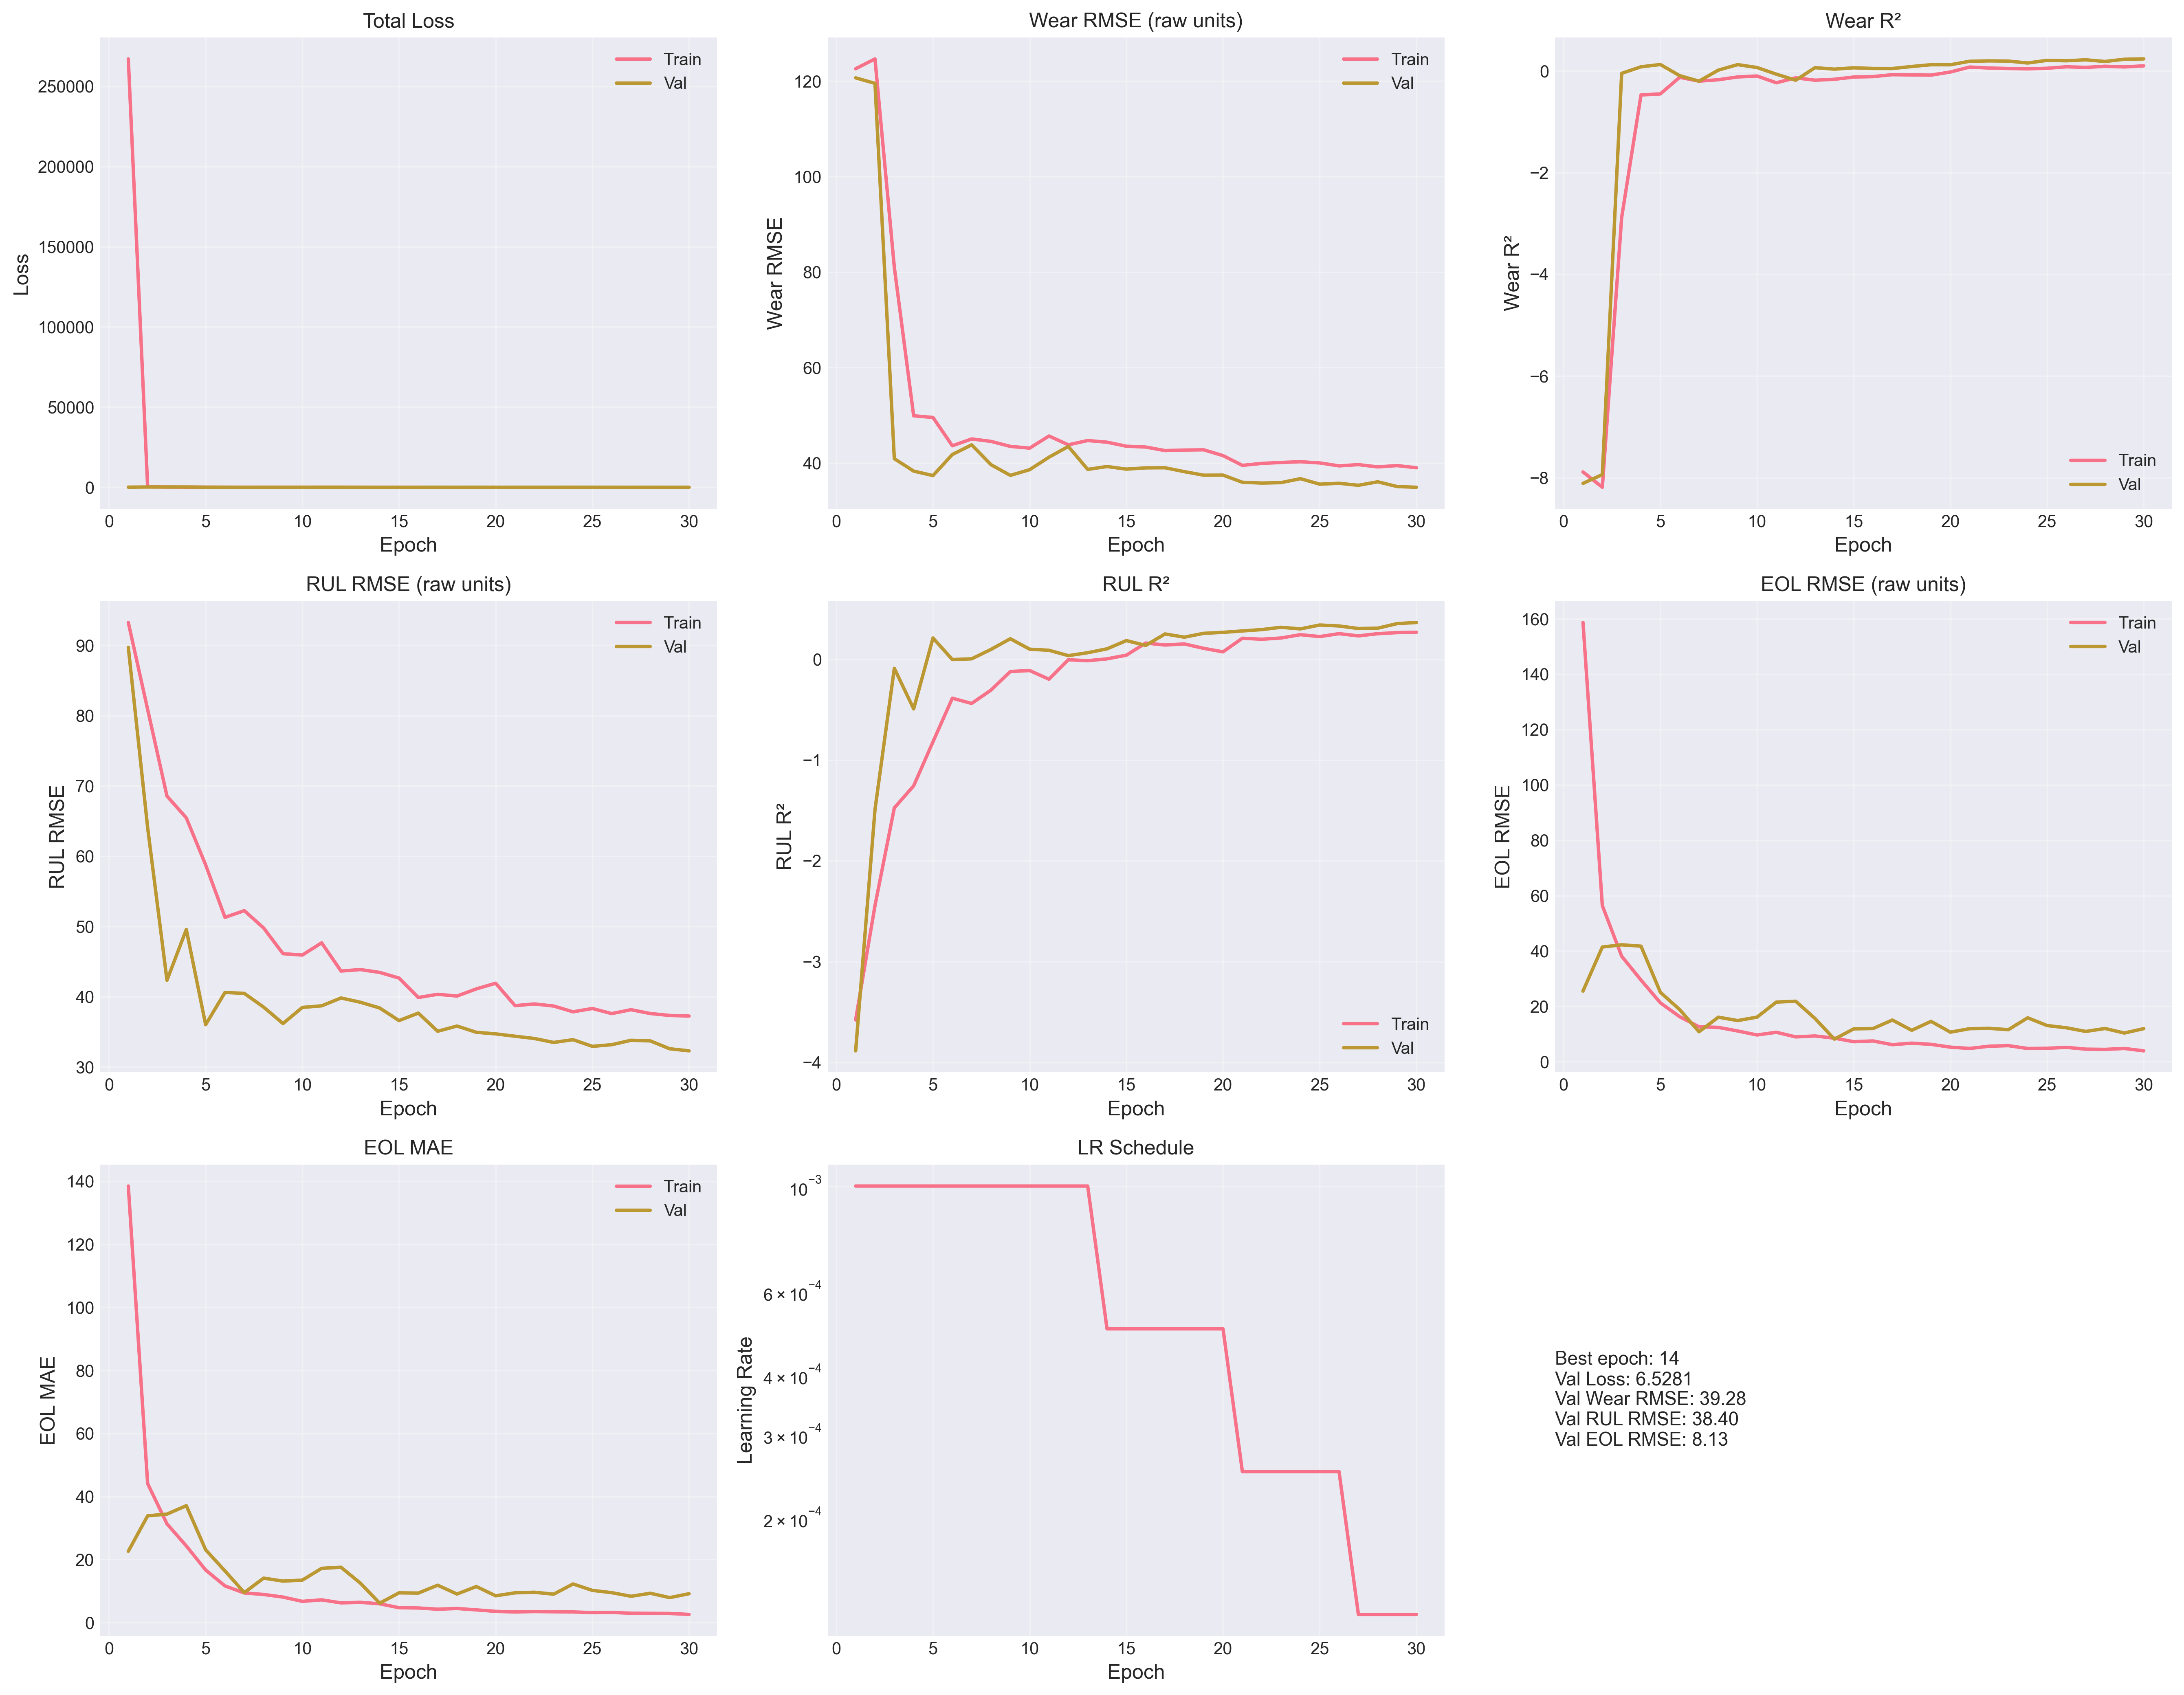

✅ Latent-EOL training history visualizations saved!


In [39]:
# ======================================================================
# CELL 13: Load Best Latent-EOL Model & Visualize Training History
# ======================================================================

# ---- Load best checkpoint ----
checkpoint = torch.load("best_latent_eol_model.pt", map_location=device, weights_only=False)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("\n✅ Loaded best latent-EOL model checkpoint")
print(f"   - Best epoch:        {checkpoint['epoch']}")
print(f"   - Val Loss:          {checkpoint['val_loss']:.4f}")
print(f"   - Val Wear RMSE:     {checkpoint['val_rmse_wear']:.2f}")
print(f"   - Val Wear R²:       {checkpoint['val_r2_wear']:.4f}")
print(f"   - Val RUL RMSE:      {checkpoint['val_rmse_rul']:.2f}")
print(f"   - Val RUL R²:        {checkpoint['val_r2_rul']:.4f}")
print(f"   - Val EOL RMSE:      {checkpoint.get('val_rmse_eol', float('nan')):.2f}")
print(f"   - Val EOL MAE:       {checkpoint.get('val_mae_eol', float('nan')):.2f}\n")


# ---- Training history plots ----
epochs_range = np.arange(1, len(history["train_loss"]) + 1)

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

# 0) Loss
ax = axes[0]
ax.plot(epochs_range, history["train_loss"], label="Train", linewidth=2)
ax.plot(epochs_range, history["val_loss"], label="Val", linewidth=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Total Loss")
ax.legend()
ax.grid(True, alpha=0.3)

# 1) Wear RMSE
ax = axes[1]
ax.plot(epochs_range, history["train_rmse_wear"], label="Train", linewidth=2)
ax.plot(epochs_range, history["val_rmse_wear"], label="Val", linewidth=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("Wear RMSE")
ax.set_title("Wear RMSE (raw units)")
ax.legend()
ax.grid(True, alpha=0.3)

# 2) Wear R²
ax = axes[2]
ax.plot(epochs_range, history["train_r2_wear"], label="Train", linewidth=2)
ax.plot(epochs_range, history["val_r2_wear"], label="Val", linewidth=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("Wear R²")
ax.set_title("Wear R²")
ax.legend()
ax.grid(True, alpha=0.3)

# 3) RUL RMSE
ax = axes[3]
ax.plot(epochs_range, history["train_rmse_rul"], label="Train", linewidth=2)
ax.plot(epochs_range, history["val_rmse_rul"], label="Val", linewidth=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("RUL RMSE")
ax.set_title("RUL RMSE (raw units)")
ax.legend()
ax.grid(True, alpha=0.3)

# 4) RUL R²
ax = axes[4]
ax.plot(epochs_range, history["train_r2_rul"], label="Train", linewidth=2)
ax.plot(epochs_range, history["val_r2_rul"], label="Val", linewidth=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("RUL R²")
ax.setTitle = ax.set_title("RUL R²")
ax.legend()
ax.grid(True, alpha=0.3)

# 5) EOL RMSE
ax = axes[5]
ax.plot(epochs_range, history["train_rmse_eol"], label="Train", linewidth=2)
ax.plot(epochs_range, history["val_rmse_eol"], label="Val", linewidth=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("EOL RMSE")
ax.set_title("EOL RMSE (raw units)")
ax.legend()
ax.grid(True, alpha=0.3)

# 6) EOL MAE
ax = axes[6]
ax.plot(epochs_range, history["train_mae_eol"], label="Train", linewidth=2)
ax.plot(epochs_range, history["val_mae_eol"], label="Val", linewidth=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("EOL MAE")
ax.set_title("EOL MAE")
ax.legend()
ax.grid(True, alpha=0.3)

# 7) Learning rate
ax = axes[7]
ax.plot(epochs_range, history["lr"], linewidth=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("Learning Rate")
ax.set_title("LR Schedule")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)

# 8) Empty / text
ax = axes[8]
ax.axis("off")
ax.text(
    0.0, 0.5,
    f"Best epoch: {checkpoint['epoch']}\n"
    f"Val Loss: {checkpoint['val_loss']:.4f}\n"
    f"Val Wear RMSE: {checkpoint['val_rmse_wear']:.2f}\n"
    f"Val RUL RMSE: {checkpoint['val_rmse_rul']:.2f}\n"
    f"Val EOL RMSE: {checkpoint.get('val_rmse_eol', float('nan')):.2f}",
    fontsize=11,
    va="center",
)

plt.tight_layout()
plt.savefig("latent_eol_training_history.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ Latent-EOL training history visualizations saved!")


In [40]:
# ======================================================================
# CELL 13.5: Define uncertainty sampling parameters
# ======================================================================

# Number of Monte-Carlo forward passes during inference
# Recommended values:
# - 20 → fast, coarse uncertainty
# - 50 → balanced (good for experiments)
# - 100 → strong research-level confidence intervals
NUM_PARTICLES = 50   # you can adjust later

print(f"🔁 NUM_PARTICLES set to {NUM_PARTICLES} for MC-Dropout inference")


🔁 NUM_PARTICLES set to 50 for MC-Dropout inference


In [41]:
# ============================================================================
# CELL 14: Hybrid MC-Dropout + Latent-EOL Uncertainty Inference
# ============================================================================

def enable_dropout(model):
    """
    Enable dropout layers during inference (for MC-Dropout).
    """
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()


@torch.no_grad()
def hybrid_mc_dropout_latent_eol(model, loader, device, n_samples=NUM_PARTICLES, split_name="val"):
    """
    Hybrid uncertainty:
      - Epistemic: MC-Dropout (stochastic forward passes)
      - Aleatoric: sampling from predicted Gaussian (mean, log-variance)
    All of this is done in *latent EOL space* and propagated to raw wear/RUL.
    
    Returns:
        pandas.DataFrame with per-cut predictions, uncertainties, and (if available) ground truth.
    """
    model.eval()
    enable_dropout(model)

    all_rows = []

    pbar = tqdm(loader, desc=f"Hybrid MC-Dropout ({split_name}, n={n_samples})")
    for X, L, Xp, Lp, params, yn, yr, eol, cutn, cutter in pbar:
        X = X.to(device)
        L = L.to(device)
        params = params.to(device)
        eol_true = eol.to(device)  # may be NaN for test

        batch_size = X.size(0)

        # We will sample in *raw units* already (wear & RUL after combining with latent EOL)
        wear_raw_samples = []
        rul_raw_samples = []
        eol_samples = []

        for _ in range(n_samples):
            preds, uncerts = model(X, L, params)

            # Means
            wear_mu = preds["wear"]          # [B] in (0,1) approx.
            rul_mu  = preds["rul"]           # [B] in (0,1) approx.
            eol_mu  = preds["eol"]           # [B] in raw units (>0)

            # Aleatoric std from log-variance heads
            wear_sigma = torch.exp(0.5 * uncerts["wear_logvar"])
            rul_sigma  = torch.exp(0.5 * uncerts["rul_logvar"])

            # eol_logvar might exist; if not, treat as deterministic
            if "eol_logvar" in uncerts:
                eol_sigma = torch.exp(0.5 * uncerts["eol_logvar"])
            else:
                eol_sigma = torch.zeros_like(eol_mu)

            # Sample from Normal(mean, sigma)  -> aleatoric + dropout (epistemic)
            eps_w = torch.randn_like(wear_mu)
            eps_r = torch.randn_like(rul_mu)
            eps_e = torch.randn_like(eol_mu)

            wear_sample_norm = wear_mu + eps_w * wear_sigma
            rul_sample_norm  = rul_mu  + eps_r * rul_sigma
            eol_sample       = eol_mu  + eps_e * eol_sigma

            # Enforce physical constraints
            wear_sample_norm = torch.clamp(wear_sample_norm, 0.0, 1.0)
            rul_sample_norm  = torch.clamp(rul_sample_norm,  0.0, 1.0)
            eol_sample       = torch.clamp(eol_sample,       1e-3)  # strictly positive EOL

            # Propagate latent EOL to raw wear & RUL
            wear_raw = wear_sample_norm * eol_sample
            rul_raw  = rul_sample_norm  * eol_sample

            wear_raw_samples.append(wear_raw.cpu())
            rul_raw_samples.append(rul_raw.cpu())
            eol_samples.append(eol_sample.cpu())

        # Stack samples: [T, B]
        wear_raw_samples = torch.stack(wear_raw_samples, dim=0)
        rul_raw_samples  = torch.stack(rul_raw_samples,  dim=0)
        eol_samples      = torch.stack(eol_samples,      dim=0)

        # Predictive means and stds (epistemic + aleatoric, all sources)
        wear_mean = wear_raw_samples.mean(dim=0)
        wear_std  = wear_raw_samples.std(dim=0)

        rul_mean  = rul_raw_samples.mean(dim=0)
        rul_std   = rul_raw_samples.std(dim=0)

        eol_mean  = eol_samples.mean(dim=0)
        eol_std   = eol_samples.std(dim=0)

        # Move ground truth to CPU for logging
        yr_cpu   = yr.cpu()
        eol_cpu  = eol_true.cpu()
        cutters  = list(cutter)
        cuts     = cutn

        for i in range(batch_size):
            row = {
                "split": split_name,
                "cutter": cutters[i],
                "cut_number": int(cuts[i]),
                "wear_pred": float(wear_mean[i]),
                "wear_std": float(wear_std[i]),
                "rul_pred": float(rul_mean[i]),
                "rul_std": float(rul_std[i]),
                "eol_pred": float(eol_mean[i]),
                "eol_std": float(eol_std[i]),
            }

            # Attach ground truth if present (NaNs on test)
            if torch.isfinite(yr_cpu[i, 3]):
                row["wear_true"] = float(yr_cpu[i, 3])
            if torch.isfinite(yr_cpu[i, 4]):
                row["rul_true"] = float(yr_cpu[i, 4])
            if torch.isfinite(eol_cpu[i]):
                row["eol_true"] = float(eol_cpu[i])

            all_rows.append(row)

    df = pd.DataFrame(all_rows)
    return df


print("\n" + "="*70)
print("🎲 Hybrid MC-Dropout + Latent-EOL Uncertainty Inference")
print("="*70 + "\n")

# Validation: has ground truth (for metrics & calibration)
val_predictions_hybrid = hybrid_mc_dropout_latent_eol(
    model, val_loader, device,
    n_samples=NUM_PARTICLES,
    split_name="val"
)

# Test: no ground truth EOL/wear/RUL, but we still get full predictive distribution
test_predictions_hybrid = hybrid_mc_dropout_latent_eol(
    model, test_loader, device,
    n_samples=NUM_PARTICLES,
    split_name="test"
)

print("✅ Hybrid uncertainty inference complete!")
print(f"   - Validation samples: {len(val_predictions_hybrid)}")
print(f"   - Test samples:       {len(test_predictions_hybrid)}\n")

# Save to disk for analysis
val_predictions_hybrid.to_csv("val_predictions_latent_eol_hybrid.csv", index=False)
test_predictions_hybrid.to_csv("test_predictions_latent_eol_hybrid.csv", index=False)
print("✅ Predictions saved:")
print("   - val_predictions_latent_eol_hybrid.csv")
print("   - test_predictions_latent_eol_hybrid.csv\n")



🎲 Hybrid MC-Dropout + Latent-EOL Uncertainty Inference



Hybrid MC-Dropout (test, n=50): 100%|██████████| 60/60 [18:20<00:00, 18.34s/it]

✅ Hybrid uncertainty inference complete!
   - Validation samples: 141
   - Test samples:       945

✅ Predictions saved:
   - val_predictions_latent_eol_hybrid.csv
   - test_predictions_latent_eol_hybrid.csv



In [42]:
# ======================================================================
# CELL 15: Uncertainty Calibration & Reliability Evaluation
# ======================================================================

from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import norm   # <-- FIXED
import numpy as np
import pandas as pd

def compute_metrics(df, label="val"):
    
    df = df.copy()
    df = df.dropna(subset=["wear_true", "rul_true"], how="any")
    
    # Extract data
    wear_true = df["wear_true"].values
    wear_pred = df["wear_pred"].values
    wear_std  = df["wear_std"].values

    rul_true  = df["rul_true"].values
    rul_pred  = df["rul_pred"].values
    rul_std   = df["rul_std"].values

    # Point metrics
    wear_rmse = np.sqrt(mean_squared_error(wear_true, wear_pred))
    rul_rmse  = np.sqrt(mean_squared_error(rul_true, rul_pred))

    wear_r2   = r2_score(wear_true, wear_pred)
    rul_r2    = r2_score(rul_true, rul_pred)

    # ---- Uncertainty-aware metrics ----

    # Negative Log Likelihood
    nll_wear = np.mean(0.5 * (np.log(2*np.pi*wear_std**2) + ((wear_true - wear_pred)**2)/(wear_std**2)))
    nll_rul  = np.mean(0.5 * (np.log(2*np.pi*rul_std**2) + ((rul_true - rul_pred)**2)/(rul_std**2)))

    # Coverage Probability Index (CPI)
    ci_low_wear = wear_pred - 2 * wear_std
    ci_high_wear = wear_pred + 2 * wear_std
    cpi_wear = np.mean((wear_true >= ci_low_wear) & (wear_true <= ci_high_wear))

    ci_low_rul = rul_pred - 2 * rul_std
    ci_high_rul = rul_pred + 2 * rul_std
    cpi_rul = np.mean((rul_true >= ci_low_rul) & (rul_true <= ci_high_rul))

    # CRPS (approx using Gaussian closed form)
    def gaussian_crps(mu, sigma, y):
        z = (y - mu) / sigma
        return sigma * (z * (2 * norm.cdf(z) - 1) + 2 * norm.pdf(z) - 1/np.sqrt(np.pi))
    
    crps_wear = np.mean(gaussian_crps(wear_pred, wear_std, wear_true))
    crps_rul  = np.mean(gaussian_crps(rul_pred, rul_std, rul_true))

    summary = pd.DataFrame({
        "Split": [label],
        "RMSE_Wear": [wear_rmse],
        "R2_Wear": [wear_r2],
        "RMSE_RUL": [rul_rmse],
        "R2_RUL": [rul_r2],
        "NLL_Wear": [nll_wear],
        "NLL_RUL": [nll_rul],
        "CPI_Wear_95%": [cpi_wear],
        "CPI_RUL_95%": [cpi_rul],
        "CRPS_Wear": [crps_wear],
        "CRPS_RUL": [crps_rul],
    })

    return summary

# Compute metrics
val_metrics = compute_metrics(val_predictions_hybrid, label="Validation")
val_metrics


,Split,RMSE_Wear,R2_Wear,RMSE_RUL,R2_RUL,NLL_Wear,NLL_RUL,CPI_Wear_95%,CPI_RUL_95%,CRPS_Wear,CRPS_RUL
0,Validation,38.04646,0.094311,39.460131,0.055036,5.281472,5.308793,0.985816,1.0,23.544679,24.27524


In [43]:
# ======================================================================
# CELL 16: IEEE-TII Publication Visualization Suite
# ======================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Ensure IEEE-style formatting
plt.rcParams.update({
    "figure.dpi": 300,
    "font.size": 11,
    "font.family": "serif",
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "lines.linewidth": 2,
})

COLOR_PRED      = "#1f77b4"  # IEEE blue
COLOR_TRUE      = "#000000"  # Black
COLOR_UNCERT    = "#ff7f0e"  # IEEE orange

def plot_ieee_timeseries(df, metric="wear", title="Wear Prediction with Uncertainty", save_name=None):
    """IEEE formatted line plot with 95% confidence interval."""
    
    df = df.dropna(subset=[f"{metric}_true"])
    df = df.sort_values(f"{metric}_true").reset_index(drop=True)

    x       = df.index.values
    y_true  = df[f"{metric}_true"].values
    y_pred  = df[f"{metric}_pred"].values
    y_std   = df[f"{metric}_std"].values

    # Confidence bounds
    ci_low  = y_pred - 2*y_std
    ci_high = y_pred + 2*y_std

    fig, ax = plt.subplots(figsize=(8,4))

    # Confidence interval shading
    ax.fill_between(x, ci_low, ci_high, color=COLOR_UNCERT, alpha=0.25, label="95% Confidence Interval")

    # Prediction
    ax.plot(x, y_pred, '-', color=COLOR_PRED, label="Predicted", marker='s', markevery=12, markersize=5)

    # Ground truth
    ax.plot(x, y_true, '-', color=COLOR_TRUE, label="Ground Truth", marker='o', markevery=12, markersize=4)

    ax.set_xlabel("Sample Index")
    ax.set_ylabel(f"{metric.upper()} Value")
    ax.set_title(title)
    ax.grid(True, alpha=0.25)
    ax.legend(loc="best", frameon=False)

    # Save in IEEE-approved formats
    if save_name:
        fig.savefig(f"{save_name}.pdf", bbox_inches="tight")
        fig.savefig(f"{save_name}.svg", bbox_inches="tight")
        fig.savefig(f"{save_name}.png", bbox_inches="tight")

    plt.show()


def plot_uncertainty_vs_progression(df, metric="wear", save_name=None):
    """Uncertainty growth with degradation stage."""
    
    df = df.copy()
    df["progress"] = df[f"{metric}_pred"] / (df[f"{metric}_pred"].max() + 1e-9)

    fig, ax = plt.subplots(figsize=(6,4))

    sns.scatterplot(
        x=df["progress"],
        y=df[f"{metric}_std"],
        color=COLOR_PRED,
        s=35,
        alpha=0.7,
        edgecolor=None,
        ax=ax
    )

    ax.set_xlabel("Degradation Progress (0 → 1)")
    ax.set_ylabel("Predictive Uncertainty (σ)")
    ax.set_title(f"{metric.upper()} Uncertainty Evolution")
    ax.grid(True, alpha=0.25)

    if save_name:
        fig.savefig(f"{save_name}.pdf", bbox_inches="tight")
        fig.savefig(f"{save_name}.svg", bbox_inches="tight")
        fig.savefig(f"{save_name}.png", bbox_inches="tight")

    plt.show()


def plot_latent_eol_distribution(df, save_name=None):
    """Distribution of predicted EOL vs true EOL (validation only)."""

    df = df.dropna(subset=["est_eol"])
    
    fig, ax = plt.subplots(figsize=(6,4))
    sns.violinplot(
        y=df["est_eol"],
        color=COLOR_PRED,
        inner="quartile",
        ax=ax
    )

    ax.axhline(df["est_eol"].median(), color="red", linestyle="--", linewidth=2, label="Median")
    ax.set_ylabel("Estimated End-of-Life (EOL)")
    ax.set_title("Latent EOL Distribution")
    ax.legend(frameon=False)

    if save_name:
        fig.savefig(f"{save_name}.pdf", bbox_inches="tight")
        fig.savefig(f"{save_name}.svg", bbox_inches="tight")
        fig.savefig(f"{save_name}.png", bbox_inches="tight")

    plt.show()


print("📈 IEEE-TII visualization suite ready.")


📈 IEEE-TII visualization suite ready.


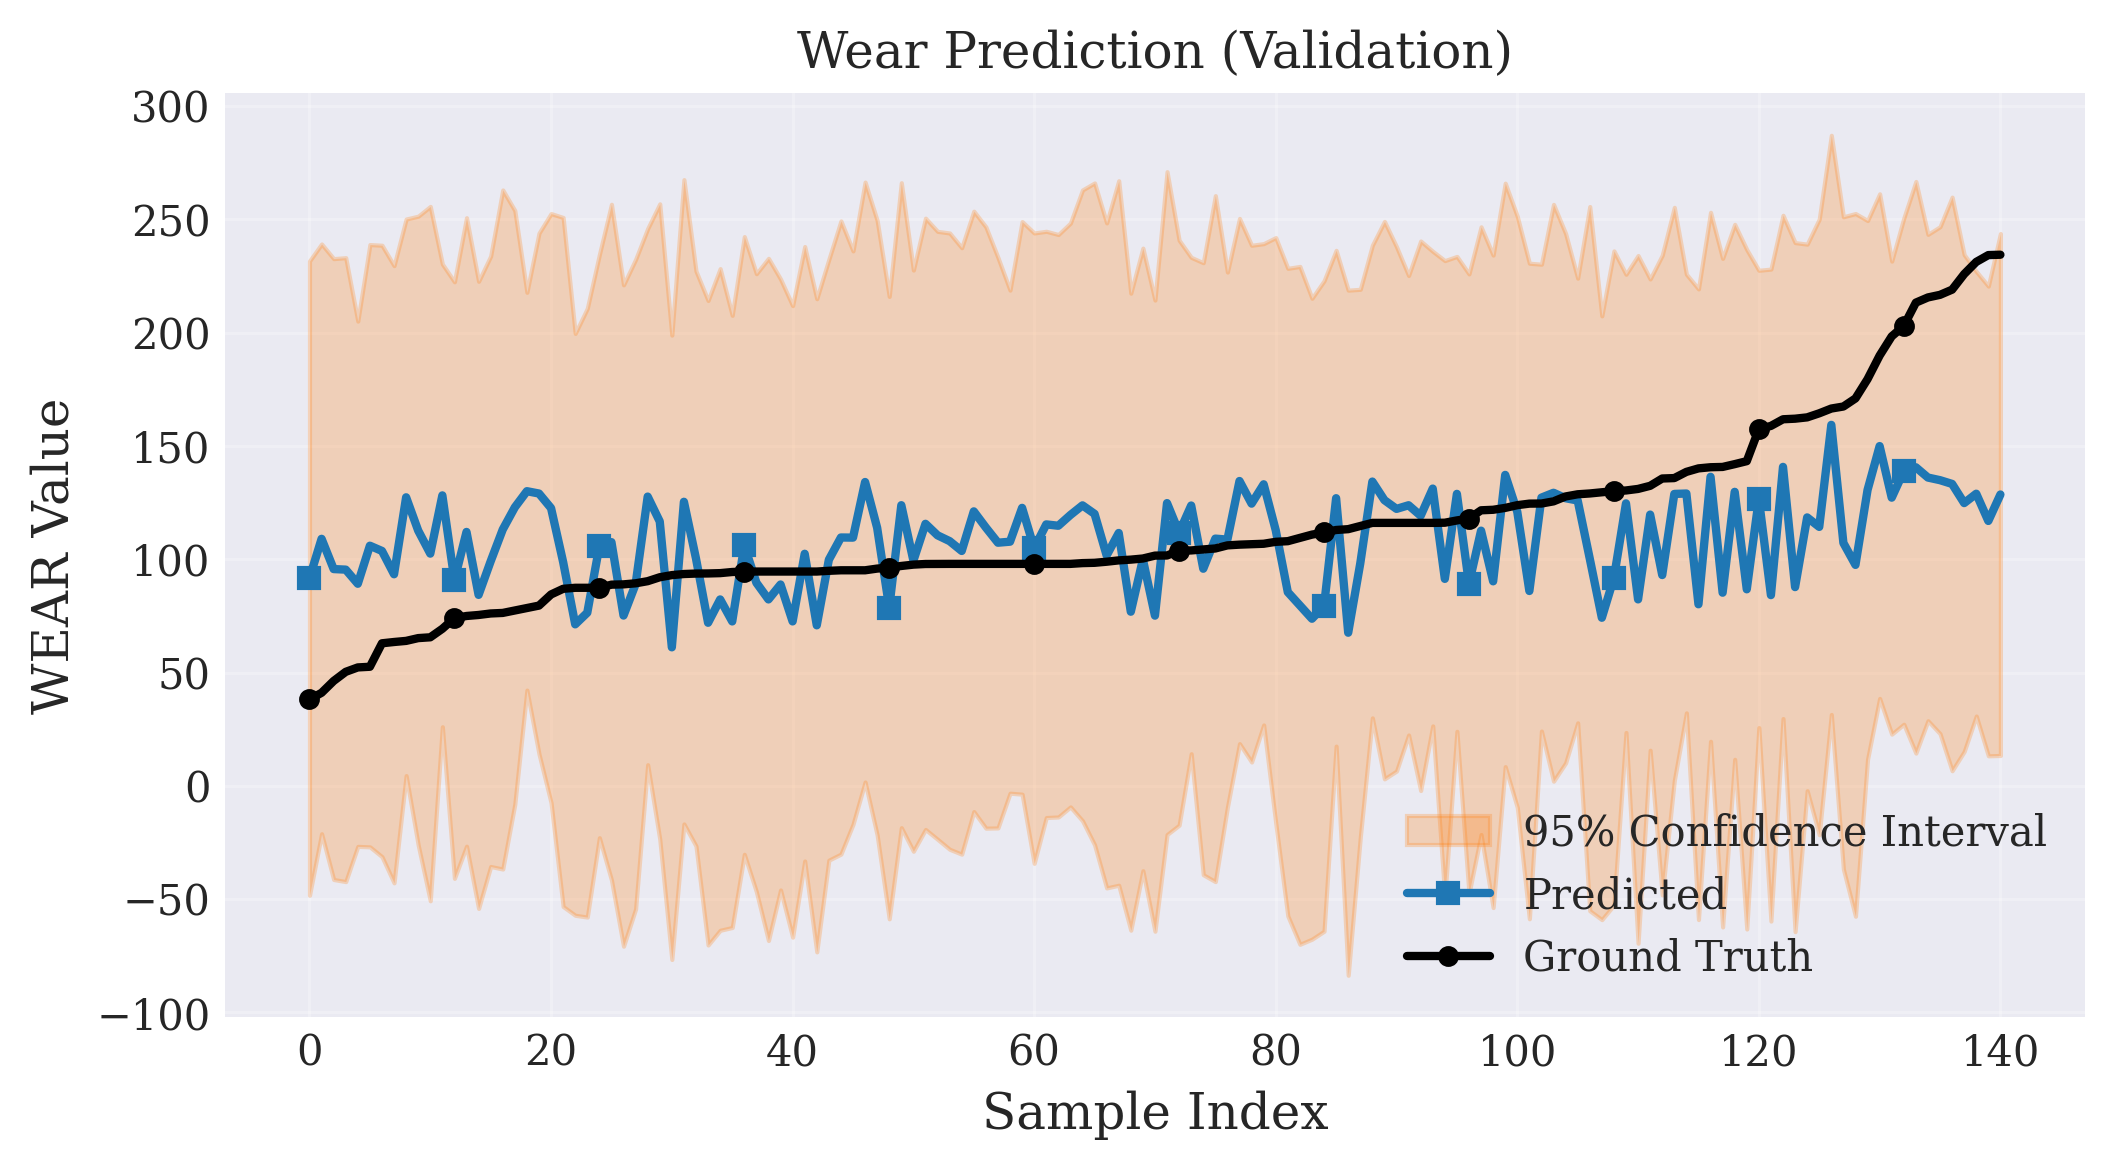

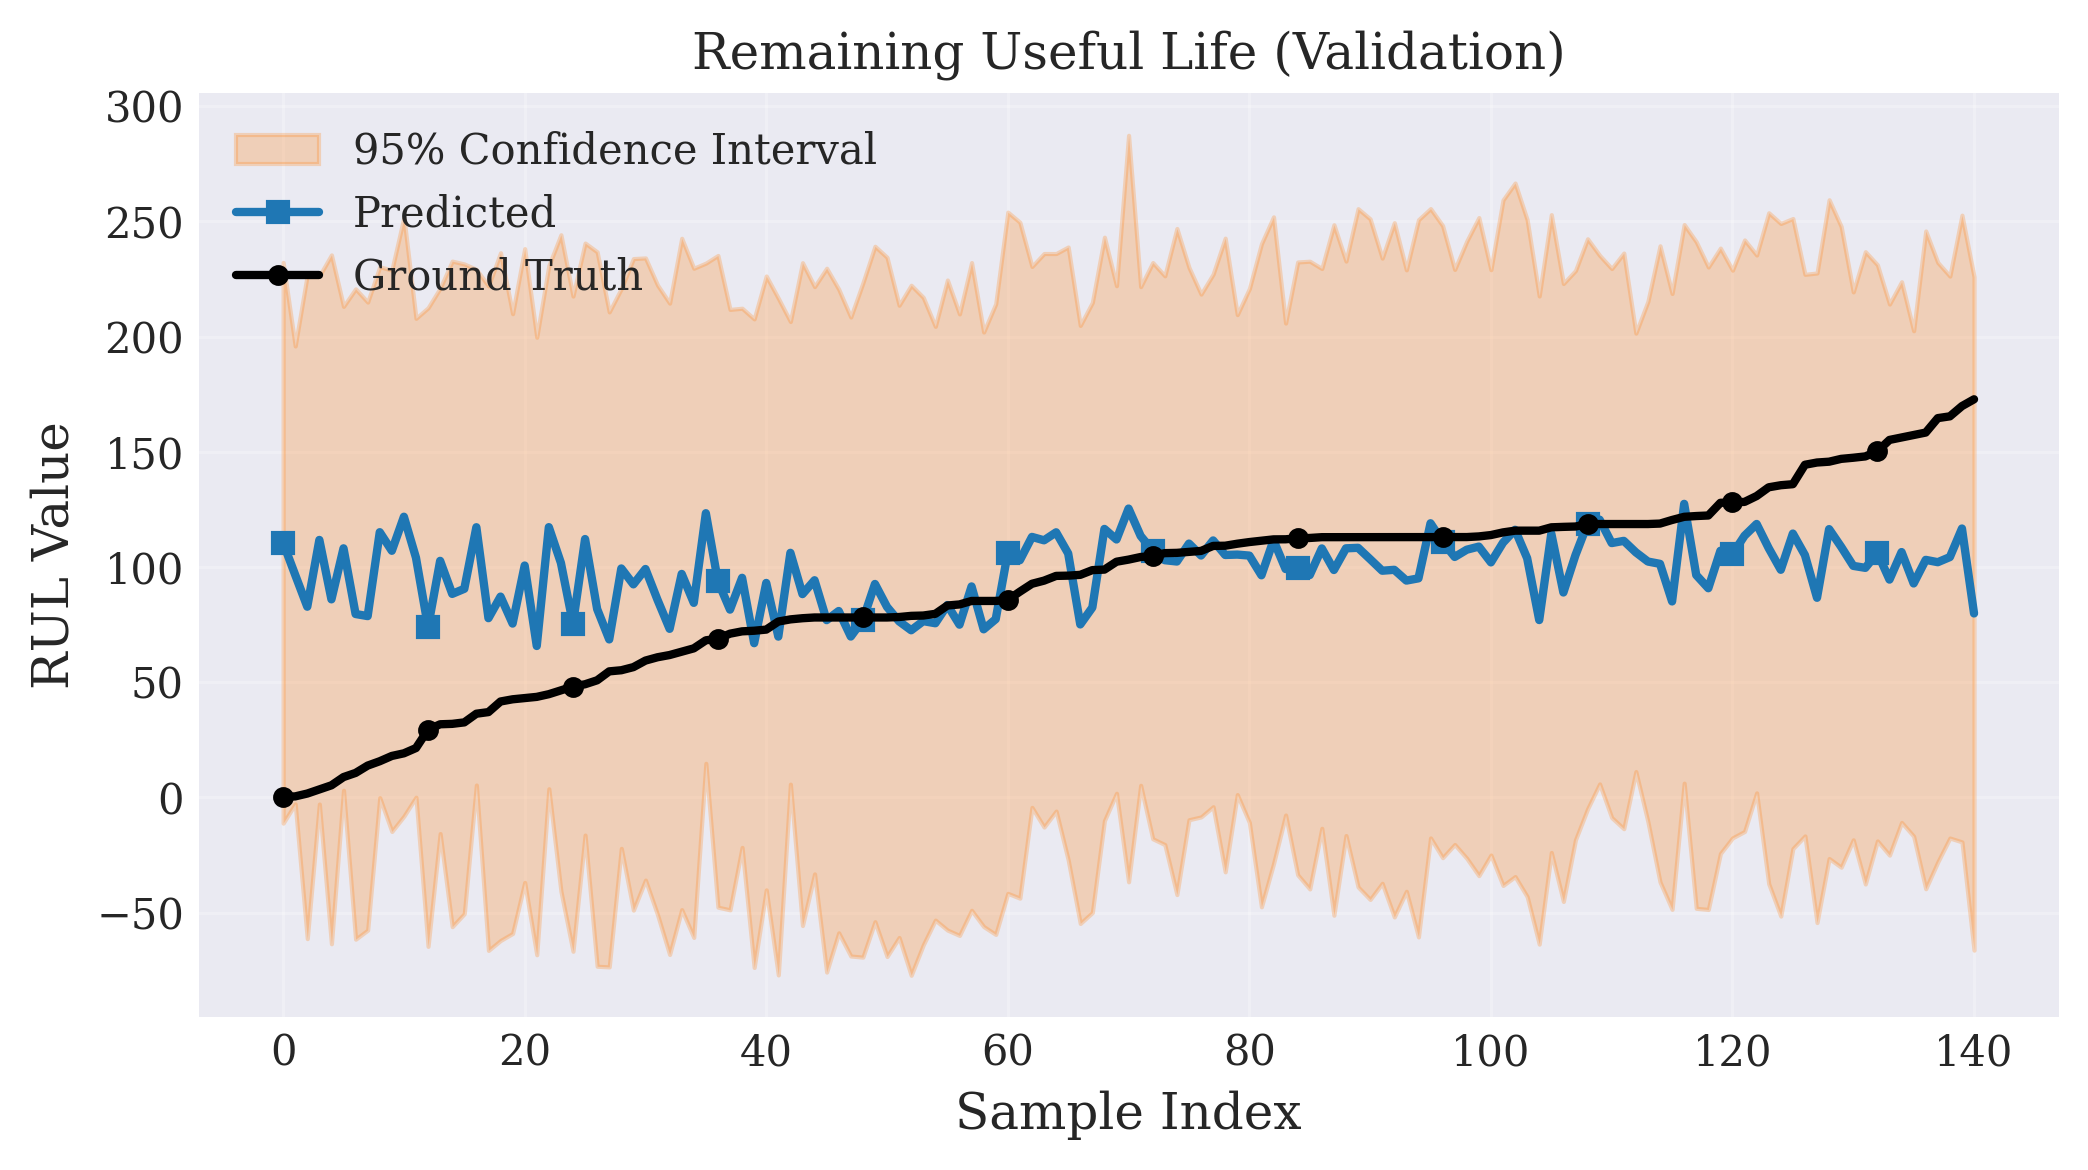

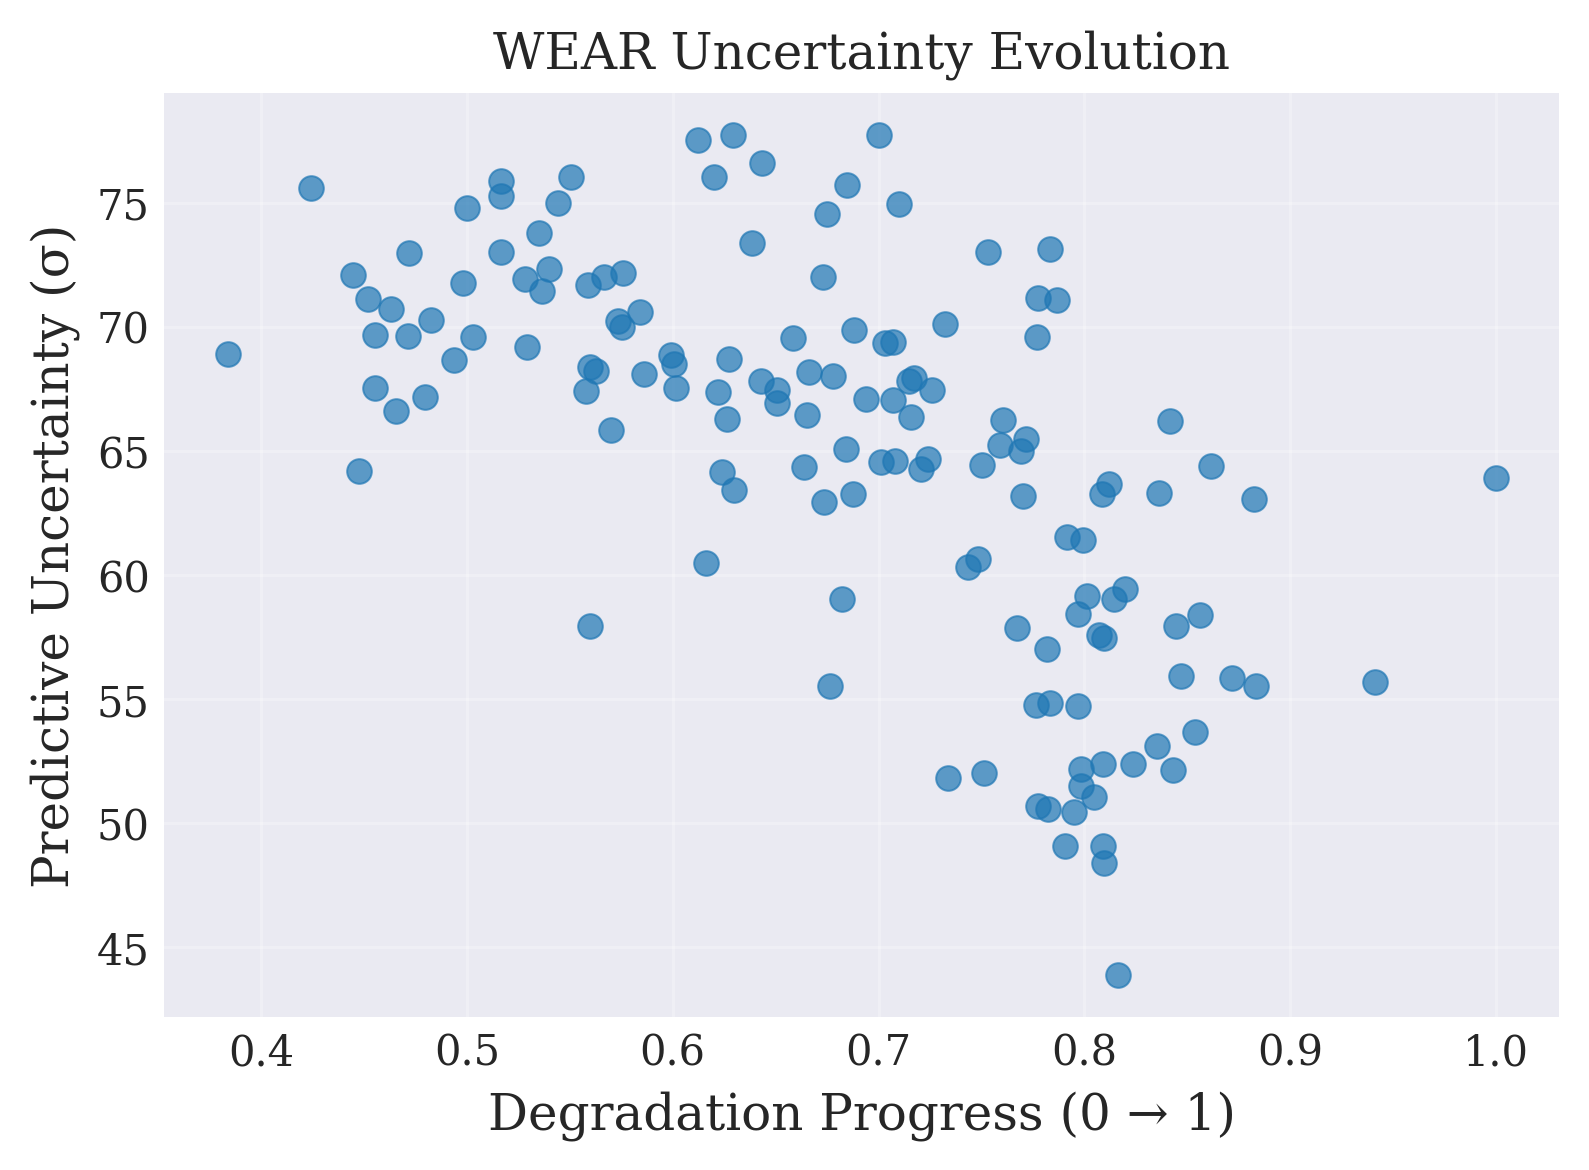

In [44]:
plot_ieee_timeseries(val_predictions_hybrid, metric="wear", title="Wear Prediction (Validation)", save_name="fig_wear_val")
plot_ieee_timeseries(val_predictions_hybrid, metric="rul", title="Remaining Useful Life (Validation)", save_name="fig_rul_val")

plot_uncertainty_vs_progression(val_predictions_hybrid, metric="wear", save_name="fig_uncertainty_progress")


In [45]:
if "est_eol" in val_predictions_hybrid.columns:
    plot_latent_eol_distribution(val_predictions_hybrid, save_name="fig_latent_eol")
